# Batch Test

1. unknown infection rate
2. multi-layer batch testing
3. adaptive to local infection rate
4. geography
5. calculation of false positive/negative in this process

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.stats import ttest_ind
from scipy.optimize import fsolve
from mpl_toolkits.mplot3d import Axes3D
from numba import njit
import time
#import batch_test_kit as btk
%load_ext autoreload
%autoreload 2

In [1]:
import torch

In [2]:
torch.cuda.is_available()

True

In [6]:
a = torch.tensor([1, 2, 3])

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
a = a.to(device)

In [8]:
a

tensor([1, 2, 3], device='cuda:0')

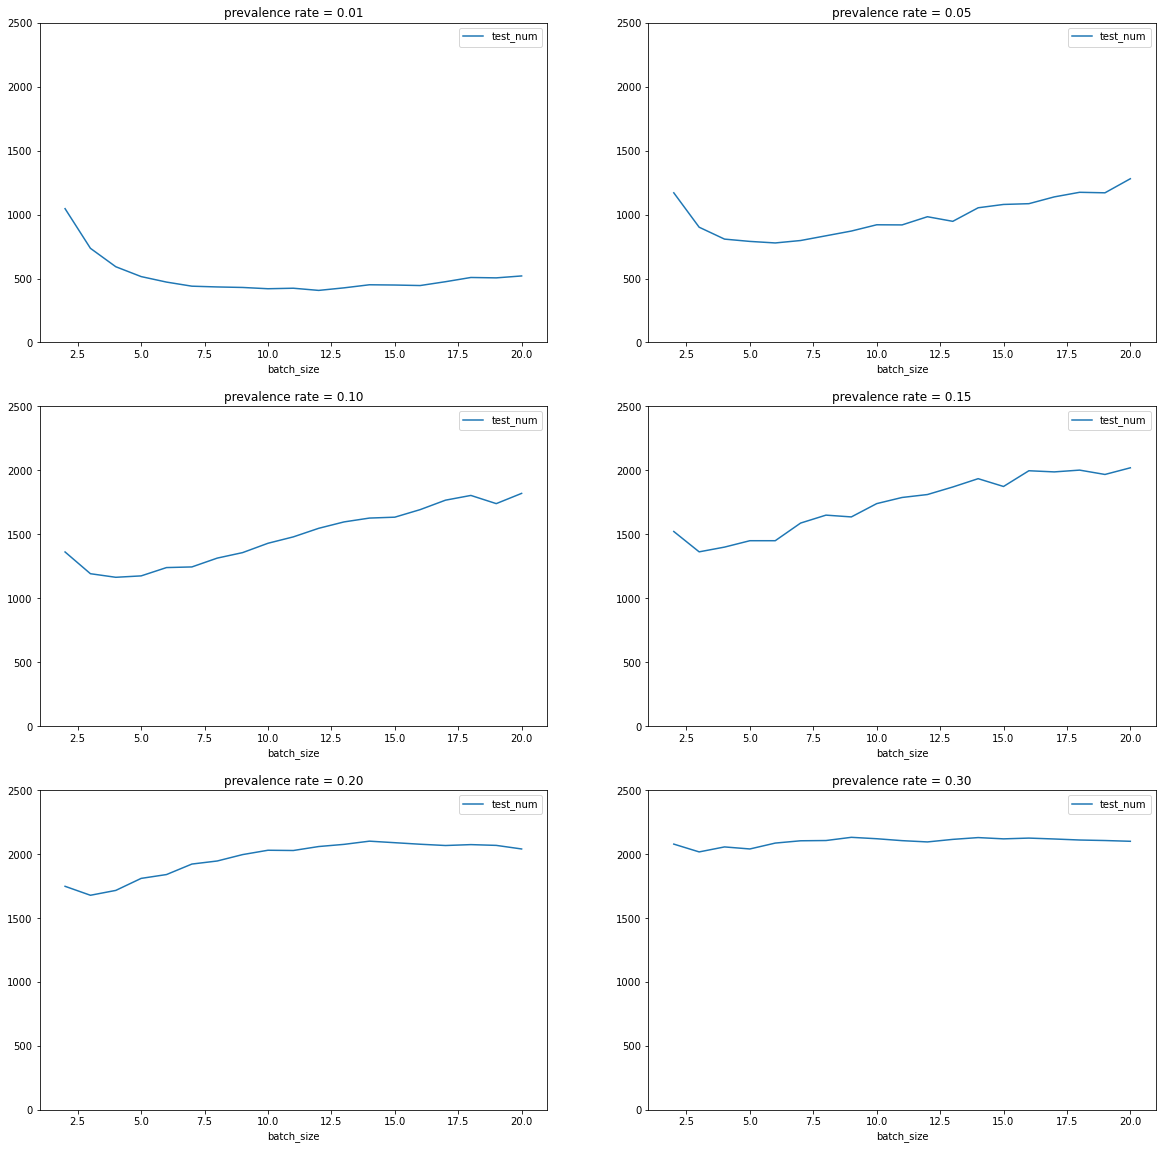

In [26]:
fig = plt.figure(figsize = (20, 20))

ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)

df[0].plot.line(x = 'batch_size', y = 'test_num', ax = ax1,
               legend = 'Prevalence Rate = 0.01')
ax1.set_ylim((0, 2500))
ax1.set_xlim((1, 21))
ax1.set_title('prevalence rate = 0.01');

df[1].plot.line(x = 'batch_size', y = 'test_num', ax = ax2,
               legend = 'Prevalence Rate = 0.01')
ax2.set_ylim((0, 2500))
ax2.set_xlim((1, 21))
ax2.set_title('prevalence rate = 0.05');

df[2].plot.line(x = 'batch_size', y = 'test_num', ax = ax3,
               legend = 'Prevalence Rate = 0.10')
ax3.set_ylim((0, 2500))
ax3.set_xlim((1, 21))
ax3.set_title('prevalence rate = 0.10');

df[3].plot.line(x = 'batch_size', y = 'test_num', ax = ax4,
               legend = 'Prevalence Rate = 0.15')
ax4.set_ylim((0, 2500))
ax4.set_xlim((1, 21))
ax4.set_title('prevalence rate = 0.15');

df[4].plot.line(x = 'batch_size', y = 'test_num', ax = ax5,
               legend = 'Prevalence Rate = 0.20')
ax5.set_ylim((0, 2500))
ax5.set_xlim((1, 21))
ax5.set_title('prevalence rate = 0.20');

df[5].plot.line(x = 'batch_size', y = 'test_num', ax = ax6,
               legend = 'Prevalence Rate = 0.30')
ax6.set_ylim((0, 2500))
ax6.set_xlim((1, 21))
ax6.set_title('prevalence rate = 0.30');

fig.savefig('fig1.png')


From the above figures, we can get following conclusions:
1. When the prevalence rate is low, the batch test is efficient and economical comparing to the conventional method.
2. However, when the prevalence rate becomes high, with the aim to catch all the positive cases, the one-layer batch test method is similar to conventional method or even worse.

## Extention to False Positive/Negative Case

Prof. Ahn mentioned that for COVID-19 RNA test, there is nearly zero false postive and 15% false negative case. I would like to use this information as a starting point. There are several metrics we want to investigate:
1. Accuracy
2. Sensitivity
3. Specificity
4. F1 Score
5. The Number of Test-kits

In [27]:
def comparsion(subject_list, batch_size, false_positive = 0, false_negative = 0.15):
    """
    """
    batch_pred, batch_num = test(subject_list, batch_size, false_positive, false_negative)
    # Batch_test
    accuracy_batch = np.mean(batch_pred.values == subject_list.values)
    precision_batch = precision_score(y_true = subject_list, y_pred  = batch_pred)
    recall_batch = recall_score(y_true = subject_list, y_pred = batch_pred)
    f1_batch = f1_score(y_true = subject_list, y_pred = batch_pred)
    # Conventional test
    conven_pred, conven_num = conventional_test(subject_list,false_positive, false_negative)
    accuracy_con = np.mean(conven_pred.values == subject_list.values)
    precision_con = precision_score(y_true = subject_list, y_pred  = conven_pred)
    recall_con = recall_score(y_true = subject_list, y_pred = conven_pred)
    f1_con = f1_score(y_true = subject_list, y_pred = conven_pred)
    
    df = pd.DataFrame({'Accuracy_Batch': [accuracy_batch],
                       'Precision_Batch': [precision_batch],
                       'Recall_Batch': [recall_batch],
                       'f1_Batch': [f1_batch],
                       'Accuracy_Conv': [accuracy_con],
                       'Precision_Con': [precision_con],
                       'Recall_Con': [recall_con],
                       'f1_Con': [f1_con],
                       'Test_Num_Difference': [(batch_num - conven_num)]
                        })
    return df
    
    
    

In [56]:
def repeat_comparison(repeat_time, batch_size, prevalence_rate,false_positive = 0, false_negative = 0.15):
    
    subject_ln = [pd.Series(np.random.binomial(size = 2000, n = 1, p = prevalence_rate)) for _ in range(repeat_time)]
    df_list = [comparsion(subject_list, batch_size, false_positive, false_negative) for subject_list in subject_ln]
    df = pd.concat(df_list)
    return df

In [62]:
subject_list = pd.Series(np.random.binomial(size = 2000, n = 1, p = 0.1))
comparsion(subject_list, 10, 0, 0.15)

Accuracy_Batch  Precision_Batch  Recall_Batch  f1_Batch  Accuracy_Conv  \
0          0.9685              1.0      0.716216  0.834646          0.984   

   Precision_Con  Recall_Con   f1_Con  Test_Num_Difference  
0            1.0    0.855856  0.92233                 -710

In [117]:
np.mean(conventional_test(subject_list, 0, 0.15)[0].values == subject_list)

0.9815

In [55]:
btk.one_batch_test_solver(0.99)

[10.516237295014893, 2.220446049250313e-16]

In [225]:
import batch_test_kit as btk
df_1 = btk.repeat_comparison(100, 11, 0.15,1000, 0.15,0.01, 0.3)
df_1.mean(axis = 0)

Accuracy_Batch           0.952450
Precision_Batch          0.948919
Recall_Batch             0.721056
f1_Batch                 0.818756
Accuracy_Con             0.969910
Precision_Con            0.939025
Recall_Con               0.854321
f1_Con                   0.894380
Test_Num_Difference   -200.860000
dtype: float64

In [57]:
1652.22/2000

0.82611

In [45]:
ttest_ind(df.Accuracy_Batch, df.Accuracy_Con)

Ttest_indResult(statistic=-9.46993832189511, pvalue=8.696272557099473e-18)

In [39]:
df = btk.repeat_comparison(100, 5, 0.05,2000, 0.15,0)
df.mean(axis = 0)

Accuracy_Batch            0.986265
Precision_Batch           1.000000
Recall_Batch              0.723665
f1_Batch                  0.838778
Accuracy_Con              0.992775
Precision_Con             1.000000
Recall_Con                0.854458
f1_Con                    0.921139
Test_Num_Difference   -1215.850000
dtype: float64

In [47]:
1215.85/2000

0.6079249999999999

In [58]:
df = btk.repeat_comparison(100, 4, 0.10,2000, 0.15,0)
df.mean(axis = 0)

Accuracy_Batch           0.972870
Precision_Batch          1.000000
Recall_Batch             0.726835
f1_Batch                 0.841400
Accuracy_Con             0.985090
Precision_Con            1.000000
Recall_Con               0.850068
f1_Con                   0.918766
Test_Num_Difference   -918.360000
dtype: float64

In [61]:
918.36/2000

0.45918000000000003

In [59]:
df = btk.repeat_comparison(100, 3, 0.15,2000, 0.15,0)
df.mean(axis = 0)

Accuracy_Batch           0.958070
Precision_Batch          1.000000
Recall_Batch             0.720366
f1_Batch                 0.837169
Accuracy_Con             0.977660
Precision_Con            1.000000
Recall_Con               0.850959
f1_Con                   0.919369
Test_Num_Difference   -680.960000
dtype: float64

In [62]:
680.96/2000

0.34048

In [60]:
df = btk.repeat_comparison(100, 3, 0.20,2000, 0.15,0)
df.mean(axis = 0)

Accuracy_Batch           0.944445
Precision_Batch          1.000000
Recall_Batch             0.722166
f1_Batch                 0.838452
Accuracy_Con             0.970040
Precision_Con            1.000000
Recall_Con               0.850217
f1_Con                   0.918943
Test_Num_Difference   -505.360000
dtype: float64

In [63]:
505.36/2000

0.25268

In [43]:
ttest_ind(df.Accuracy_Batch, df.Accuracy_Con)

Ttest_indResult(statistic=-30.431975986661673, pvalue=1.3634397276589862e-76)

In [30]:
type(df.mean(axis = 0))

pandas.core.series.Series

In [63]:
btk.comparsion(subject_list, 10, 0.15, 0)

Accuracy_Batch  Precision_Batch  Recall_Batch  f1_Batch  Accuracy_Con  \
0          0.9685              1.0      0.716216  0.834646         0.986   

   Precision_Con  Recall_Con    f1_Con  Test_Num_Difference  
0            1.0    0.873874  0.932692                 -690

In [106]:
btk.classification(0, 0.9, 0.9)

1

In [17]:
def one_batch_test_solver(q,n_initial_guess = 2):
    
    
    func = lambda n : n**2*(q ** n) * np.log(q) + 1
    n_solution = fsolve(func, n_initial_guess)
    
    return [float(n_solution), float(func(n_solution))]
    
    

In [18]:
def one_batch_test_num(batch_size, q, population = 2000):
    return float(population * (1/batch_size + 1 - q**batch_size))

In [19]:
def sequential_batch_test_num(batch_size, q, population = 2000):
    return float(population * ((2-q**batch_size)/batch_size + (1 - q**batch_size) ** 2))

In [20]:
def sequential_batch_test_solver(q, n_initial_guess = 2):
    func = lambda n: -2/n**2 + 1/n**2 * q ** n - 1/n* np.log(q) * q**n + 2*np.log(q)* q ** (2*n) - 2*np.log(q)*q**(n)
    n_solution = fsolve(func, n_initial_guess)
    return [float(n_solution), float(func(n_solution))]
    

In [21]:
def optimal_batch_size(start, end, step_size, method = 'one_batch' ,n_initial_guess = 2):
    q_list = pd.Series(np.arange(start, end, step_size))
    if method == 'one_batch':
        temp = q_list.apply(one_batch_test_solver, args = (n_initial_guess,))
    elif method == 'sequential_batch':
        temp = q_list.apply(sequential_batch_test_solver, args = (n_initial_guess,))
    else:
        raise('Check method')        
    temp = temp.apply(pd.Series)
    batch_size, value = temp[0], temp[1]
    return batch_size, value

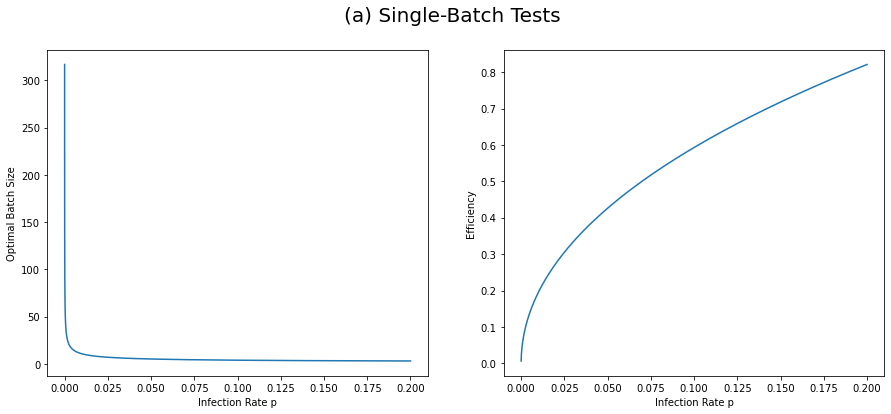

In [24]:
fig1 = plt.figure(figsize = (15, 6))

ax1 = fig1.add_subplot(121)
ax2 = fig1.add_subplot(122)
q_list = pd.Series(np.arange(0.8, 0.999999, 0.00001))
one_batch_opt,_ = optimal_batch_size(0.8, 0.999999, 0.00001, n_initial_guess = 2)
df = pd.concat([q_list, one_batch_opt], axis = 1)
df.columns = ['q', 'opt_batch_size']
one_batch_test_kit = df.apply(lambda x: one_batch_test_num(x.opt_batch_size,x.q, 2000), axis = 1)
ax1.plot(1-q_list, one_batch_opt);
ax1.set_xlabel('Infection Rate p')
ax1.set_ylabel('Optimal Batch Size')
#ax1.set_title('Test with One Batch')

ax2.plot(1-q_list, one_batch_test_kit/2000);
ax2.set_xlabel('Infection Rate p')
ax2.set_ylabel('Efficiency ')
#ax2.set_title('Test with One Batch');

fig1.suptitle('(a) Single-Batch Tests', fontsize = 20)

fig1.savefig('fig2_a.eps')

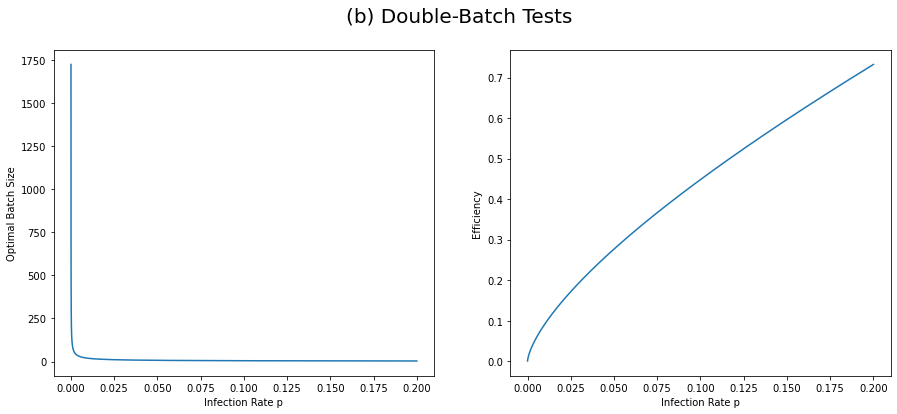

In [28]:
fig2 = plt.figure(figsize = (15, 6))

ax1 = fig2.add_subplot(121)
ax2 = fig2.add_subplot(122)
q_list = pd.Series(np.arange(0.8, 0.999999, 0.00001))
sequential_batch_opt,_ = optimal_batch_size(0.8, 0.999999, 0.00001,method = 'sequential_batch', n_initial_guess = 2)
df = pd.concat([q_list, sequential_batch_opt], axis = 1)
df.columns = ['q', 'opt_batch_size']
sequential_batch_test_kit = df.apply(lambda x: sequential_batch_test_num(x.opt_batch_size,x.q, 2000), axis = 1)
ax1.plot(1-q_list, sequential_batch_opt);
ax1.set_xlabel('Infection Rate p')
ax1.set_ylabel('Optimal Batch Size')
#ax1.set_title('Test with One Batch')

ax2.plot(1-q_list, sequential_batch_test_kit/2000);
ax2.set_xlabel('Infection Rate p')
ax2.set_ylabel('Efficiency ')
#ax2.set_title('Test with One Batch');

fig2.suptitle('(b) Double-Batch Tests', fontsize = 20)

fig2.savefig('fig2_b.png')

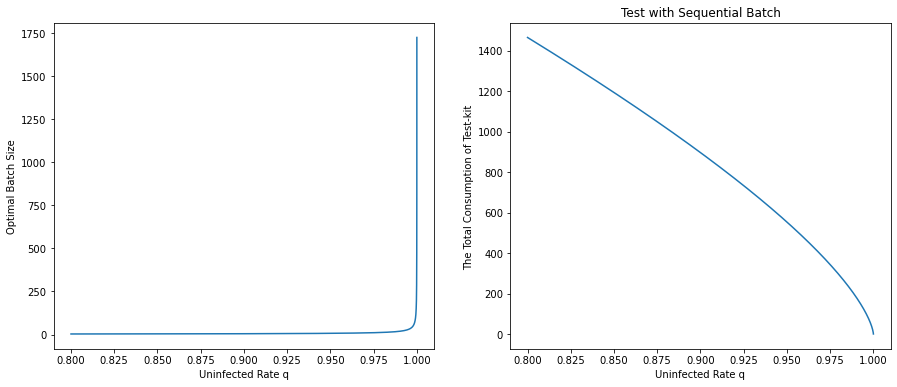

In [26]:
fig2 = plt.figure(figsize = (15, 6))

ax1 = fig2.add_subplot(121)
ax2 = fig2.add_subplot(122)
q_list = pd.Series(np.arange(0.8, 0.999999, 0.00001))
sequential_batch_opt,_ = optimal_batch_size(0.8, 0.999999, 0.00001,method = 'sequential_batch', n_initial_guess = 2)
df = pd.concat([q_list, sequential_batch_opt], axis = 1)
df.columns = ['q', 'opt_batch_size']
sequential_batch_test_kit = df.apply(lambda x: sequential_batch_test_num(x.opt_batch_size,x.q, 2000), axis = 1)
ax1.plot(q_list, sequential_batch_opt);
ax1.set_xlabel('Uninfected Rate q')
ax1.set_ylabel('Optimal Batch Size')
#ax1.set_title('Test with Sequential Batch')

ax2.plot(q_list, sequential_batch_test_kit);
ax2.set_xlabel('Uninfected Rate q')
ax2.set_ylabel('The Total Consumption of Test-kit ')
ax2.set_title('Test with Sequential Batch');

fig2.savefig('fig2_b.eps')

In [81]:
temp = pd.read_excel('opt batch size.xlsx', sheet_name = '#tests')

In [82]:
p_prob = pd.Series([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
                   0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
                   0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19,
                   0.2, 0.21, 0.22, 0.23, 0.24, 0.25])
n_num = pd.Series(np.arange(1, 36))

In [83]:
test_num = pd.Series(temp.loc[1].values[1:].astype(float))

In [84]:
df_list = [pd.concat([pd.Series(np.repeat(p_prob[i], 35)),
                     n_num,
                     pd.Series(temp.loc[i].values[1:].astype(float))], axis = 1) for i in range(len(p_prob))]
df = pd.concat(df_list, axis = 0)
df.columns = ['p', 'n_num', 'test_num']

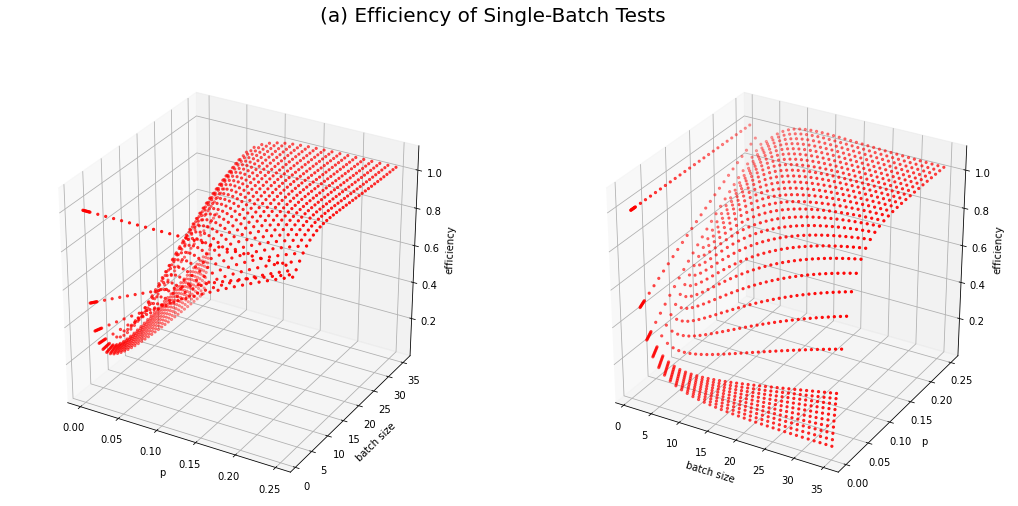

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [86]:
fig_3d = plt.figure(figsize = (18, 8))
ax1 = fig_3d.add_subplot(121, projection = '3d')

x = df.p
y = df.n_num
z = df.test_num/2000

ax1.scatter(x, y, z, c = 'r', marker = '.')

ax1.set_xlabel('p')
ax1.set_ylabel('batch size')
ax1.set_zlabel('efficiency')

ax2 = fig_3d.add_subplot(122, projection = '3d')
ax2.scatter(df.n_num, df.p, z, c = 'r', marker = '.')
ax2.set_xlabel('batch size')
ax2.set_ylabel('p')
ax2.set_zlabel('efficiency')

fig_3d.suptitle('(a) Efficiency of Single-Batch Tests', fontsize = 20)
plt.show()
fig_3d.savefig('expected_rate_tests_one_batch.eps')

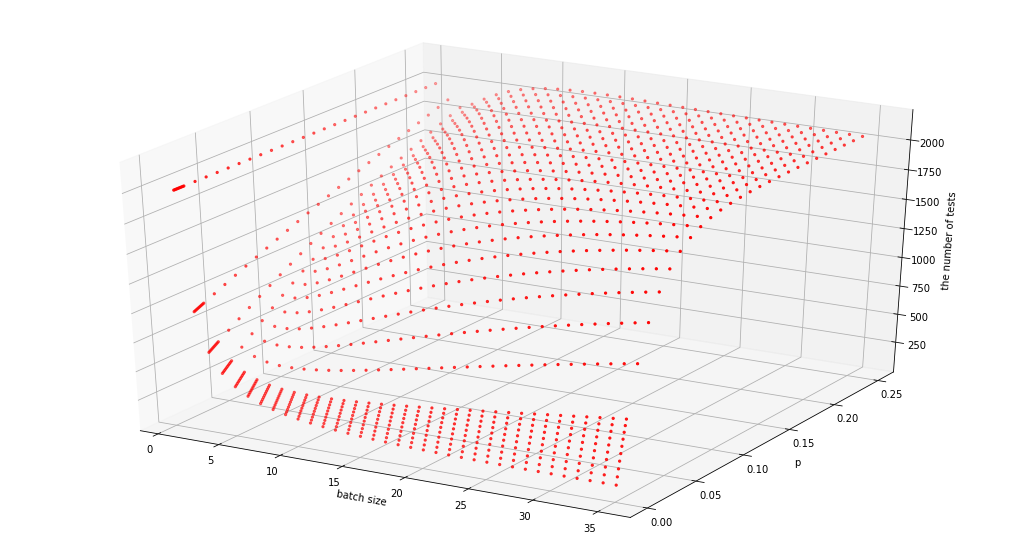

In [862]:
fig_3d_1 = plt.figure(figsize = (18, 10))
ax = fig_3d_1.add_subplot(121, projection = '3d')

x = df.n_num
y = df.p
z = df.test_num

ax.scatter(x, y, z, c = 'r', marker = '.')

ax.set_xlabel('batch size')
ax.set_ylabel('p')
ax.set_zlabel('the number of tests')

plt.show()
fig_3d_1.savefig('figure2_3d.png')

In [88]:
temp = pd.read_excel('opt batch size.xlsx', sheet_name='true+')
temp.drop('sens=.999', inplace = True, axis = 1)
specificity = pd.Series([0.75, 0.76, 0.77, 0.78, 0.79,
                        0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86,0.87,0.88, 0.89,
                        0.90])
df_list = [pd.concat([pd.Series(np.repeat(p_prob[i], 16)),
                     specificity,
                     pd.Series(temp.loc[i].values.astype(float))], axis = 1) for i in range(len(p_prob))]
df = pd.concat(df_list, axis = 0)
df.columns = ['p', 'specificity', 'true_positive']

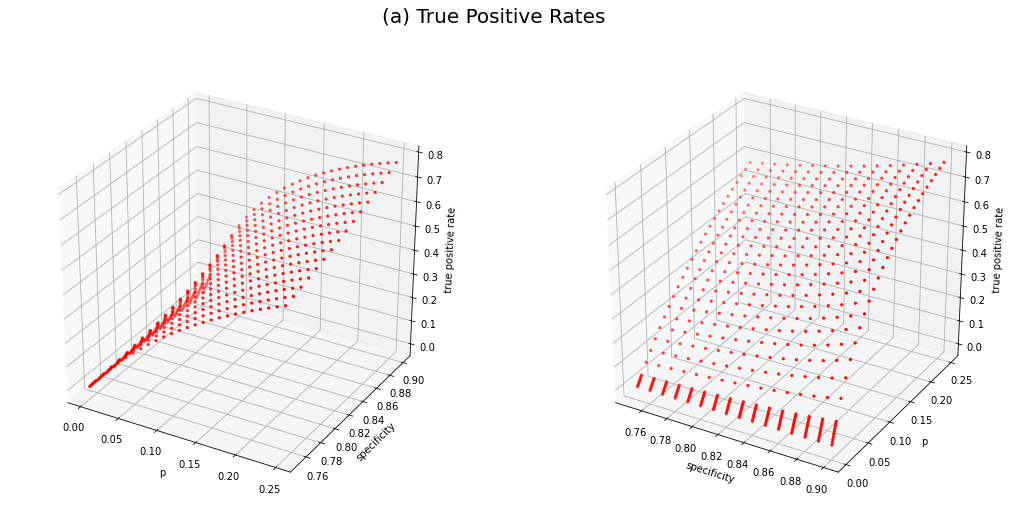

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [90]:
fig_3d = plt.figure(figsize = (18, 8))
ax1 = fig_3d.add_subplot(121, projection = '3d')

x = df.p
y = df.specificity
z = df.true_positive

ax1.scatter(x, y, z, c = 'r', marker = '.')

ax1.set_xlabel('p')
ax1.set_ylabel('specificity')
ax1.set_zlabel('true positive rate')

ax2 = fig_3d.add_subplot(122, projection = '3d')
ax2.scatter(df.specificity, df.p, z, c = 'r', marker = '.')
ax2.set_xlabel('specificity')
ax2.set_ylabel('p')
ax2.set_zlabel('true positive rate')




fig_3d.suptitle('(a) True Positive Rates', fontsize = 20)
plt.show()
fig_3d.savefig('True Positive Rates.eps')

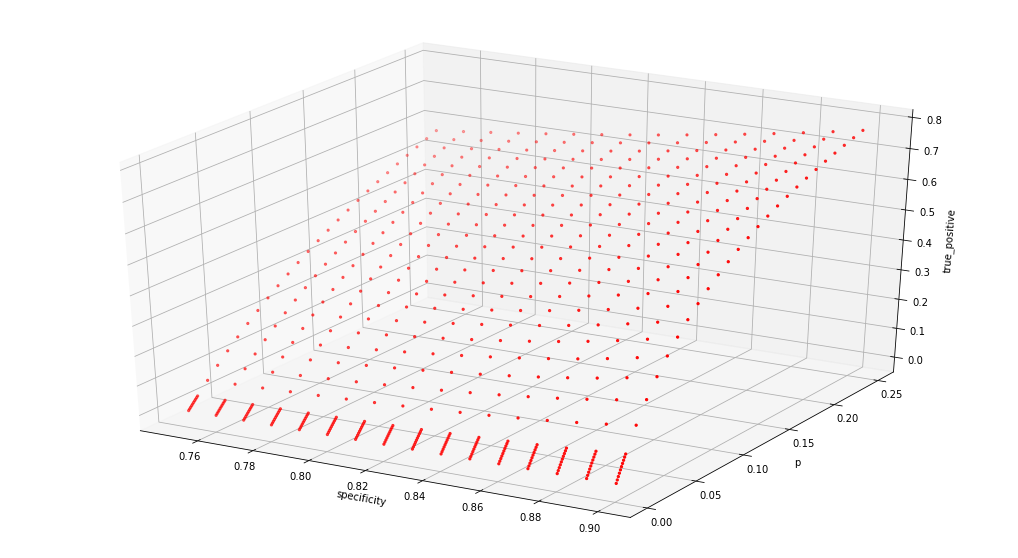

In [894]:
fig_3d_3 = plt.figure(figsize = (18, 10))
ax = fig_3d_3.add_subplot(111, projection = '3d')

y = df.p
x = df.specificity
z = df.true_positive

ax.scatter(x, y, z, c = 'r', marker = '.')

ax.set_ylabel('p')
ax.set_xlabel('specificity')
ax.set_zlabel('true_positive')

plt.show()
fig_3d_3.savefig('true_positive_3d_2.png')

In [3]:
temp = pd.read_excel('opt batch size.xlsx', sheet_name='nsize1')

temp.drop('Unnamed: 0', inplace = True, axis = 1)
specificity = pd.Series([0.75, 0.76, 0.77, 0.78, 0.79,
                        0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86,0.87,0.88, 0.89,
                        0.90])
df_list = [pd.concat([pd.Series(np.repeat(p_prob[i], 16)),
                     specificity,
                     pd.Series(temp.loc[i].values.astype(float))], axis = 1) for i in range(len(p_prob))]
df = pd.concat(df_list, axis = 0)
df.columns = ['p', 'specificity', 'true_negative']

KeyError: "['Unnamed:0'] not found in axis"

In [26]:
temp = pd.read_excel('opt batch size.xlsx', sheet_name='nsize1')
temp.drop('Unnamed: 0', inplace = True, axis = 1)
beta = pd.Series(np.arange(0.1, 0.26, 0.01))
p_prob = pd.Series([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
                   0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
                   0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19,
                   0.2, 0.21, 0.22, 0.23, 0.24, 0.25])
df_list = [pd.concat([pd.Series(np.repeat(p_prob[i], 16)),
                     beta,
                     pd.Series(temp.loc[i].values.astype(float))], axis = 1) for i in range(len(p_prob))]
df = pd.concat(df_list, axis = 0)
df.columns = ['p', 'beta', 'nsize' ]

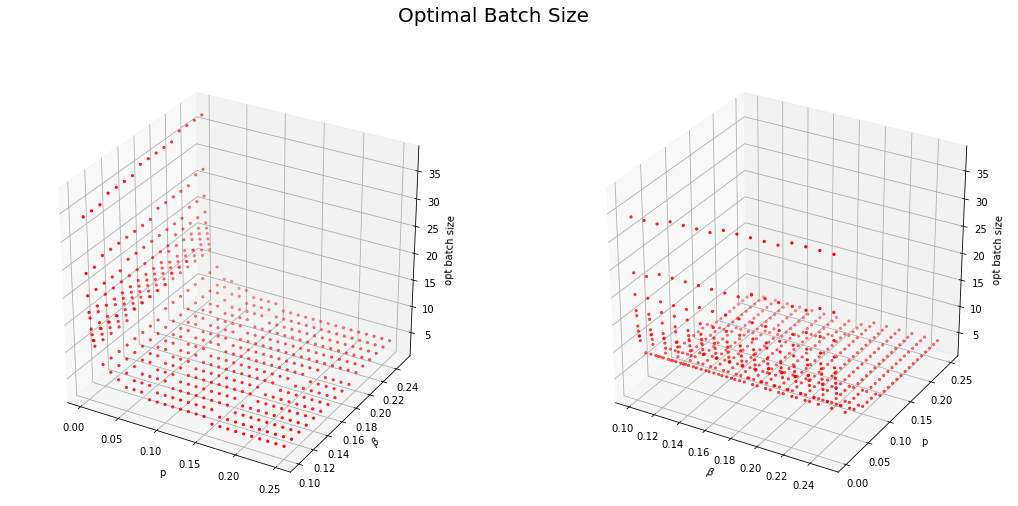

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [29]:
fig_3d = plt.figure(figsize = (18, 8))
ax1 = fig_3d.add_subplot(121, projection = '3d')

x = df.p
y = df.beta
z = df.nsize

ax1.scatter(x, y, z, c = 'r', marker = '.')

ax1.set_xlabel('p')
ax1.set_ylabel(r'$\beta$')
ax1.set_zlabel('opt batch size')

ax2 = fig_3d.add_subplot(122, projection = '3d')
ax2.scatter(y, x, z, c = 'r', marker = '.')
ax2.set_xlabel(r'$\beta$')
ax2.set_ylabel('p')
ax2.set_zlabel('opt batch size')




fig_3d.suptitle('Optimal Batch Size', fontsize = 20)
plt.show()
fig_3d.savefig('fig2.eps')

In [134]:
temp = pd.read_csv('ppv.csv')
temp.drop('Unnamed: 0', inplace = True, axis = 1)
beta = pd.Series(np.arange(0.1, 0.26, 0.01))
p_prob = pd.Series([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
                   0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
                   0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19,
                   0.2, 0.21, 0.22, 0.23, 0.24, 0.25])
df_list = [pd.concat([pd.Series(np.repeat(p_prob[i], 16)),
                     1-beta,
                     pd.Series(temp.loc[i].values.astype(float))], axis = 1) for i in range(len(p_prob))]
df = pd.concat(df_list, axis = 0)
df.columns = ['p', 'specificity', 'ppv' ]

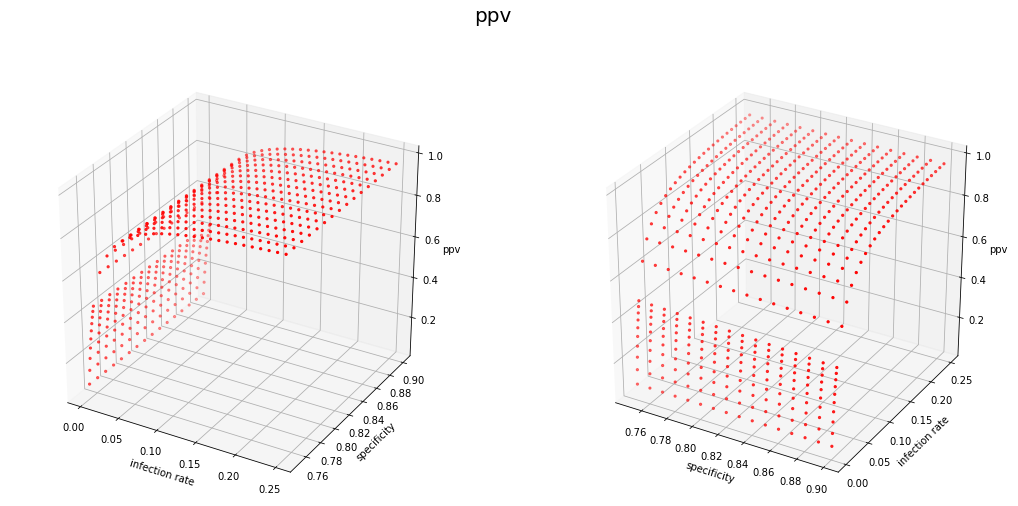

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [135]:
fig_3d = plt.figure(figsize = (18, 8))
ax1 = fig_3d.add_subplot(121, projection = '3d')

x = df.p
y = df.specificity
z = df.ppv

ax1.scatter(x, y, z, c = 'r', marker = '.')

ax1.set_xlabel('infection rate')
ax1.set_ylabel('specificity')
ax1.set_zlabel('ppv')

ax2 = fig_3d.add_subplot(122, projection = '3d')
ax2.scatter(y, x, z, c = 'r', marker = '.')
ax2.set_xlabel('specificity')
ax2.set_ylabel('infection rate')
ax2.set_zlabel('ppv')




fig_3d.suptitle('ppv', fontsize = 20)
plt.show()
fig_3d.savefig('fig2_a.eps')


In [138]:
temp = pd.read_csv('npv.csv')
temp.drop('Unnamed: 0', inplace = True, axis = 1)
beta = pd.Series(np.arange(0.1, 0.26, 0.01))
p_prob = pd.Series([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
                   0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
                   0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19,
                   0.2, 0.21, 0.22, 0.23, 0.24, 0.25])
df_list = [pd.concat([pd.Series(np.repeat(p_prob[i], 16)),
                     1-beta,
                     pd.Series(temp.loc[i].values.astype(float))], axis = 1) for i in range(len(p_prob))]
df = pd.concat(df_list, axis = 0)
df.columns = ['p', 'specificity', 'npv' ]

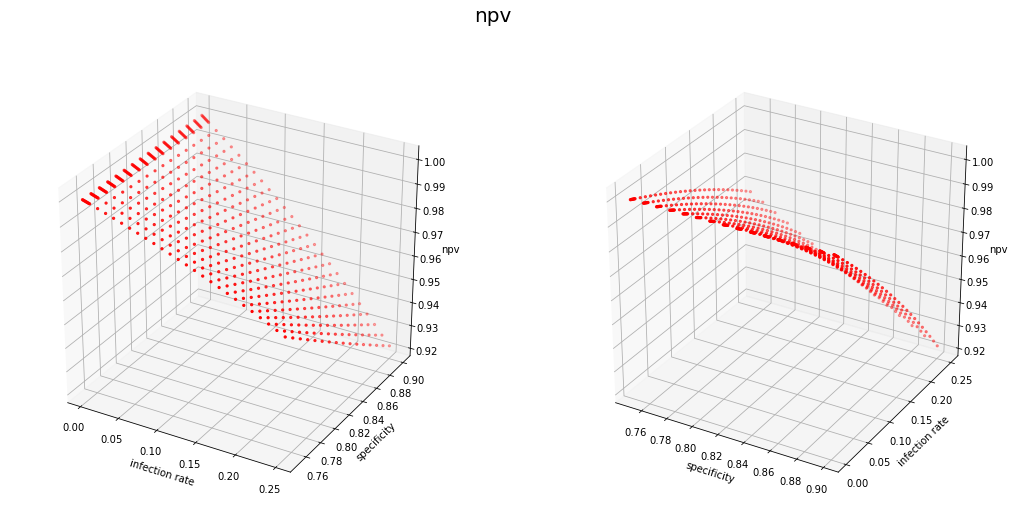

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [139]:
fig_3d = plt.figure(figsize = (18, 8))
ax1 = fig_3d.add_subplot(121, projection = '3d')

x = df.p
y = df.specificity
z = df.npv

ax1.scatter(x, y, z, c = 'r', marker = '.')

ax1.set_xlabel('infection rate')
ax1.set_ylabel('specificity')
ax1.set_zlabel('npv')

ax2 = fig_3d.add_subplot(122, projection = '3d')
ax2.scatter(y, x, z, c = 'r', marker = '.')
ax2.set_xlabel('specificity')
ax2.set_ylabel('infection rate')
ax2.set_zlabel('npv')




fig_3d.suptitle('npv', fontsize = 20)
plt.show()
fig_3d.savefig('fig2_b.eps')

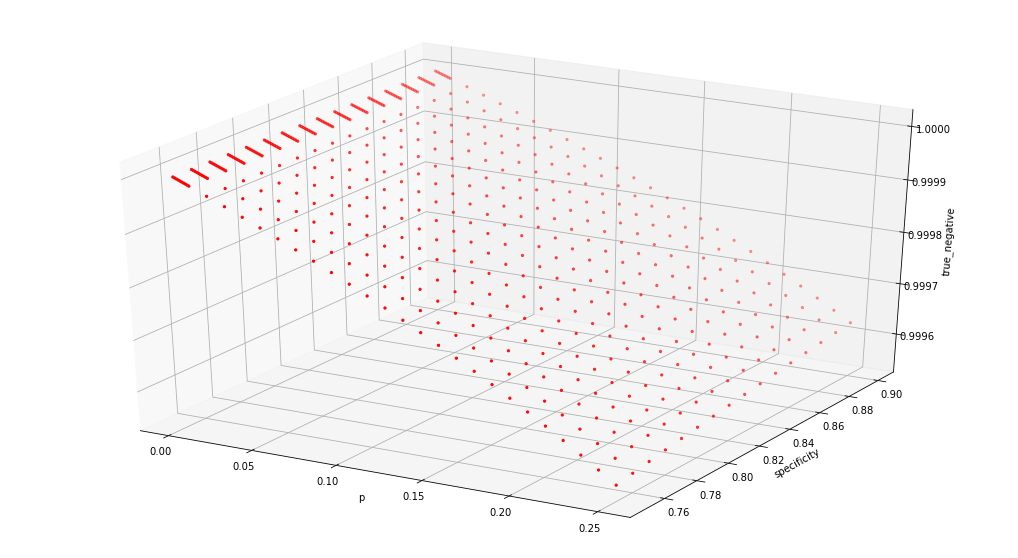

In [899]:
fig_3d_4 = plt.figure(figsize = (18, 10))
ax = fig_3d_4.add_subplot(111, projection = '3d')

x = df.p
y = df.specificity
z = df.true_negative

ax.scatter(x, y, z, c = 'r', marker = '.')

ax.set_xlabel('p')
ax.set_ylabel('specificity')
ax.set_zlabel('true_negative')

plt.show()
fig_3d_4.savefig('true_negative_3d_1.png')

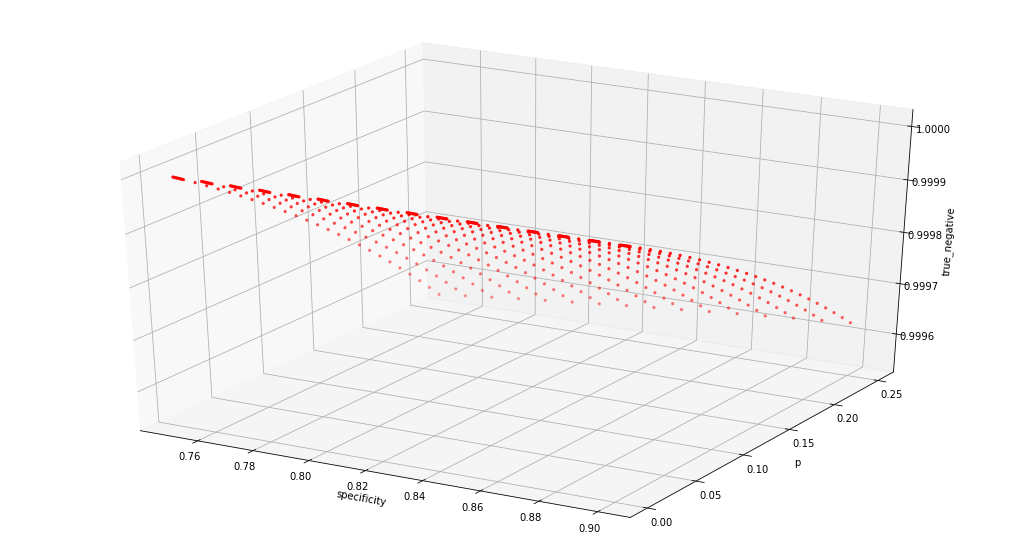

In [898]:
fig_3d_5 = plt.figure(figsize = (18, 10))
ax = fig_3d_5.add_subplot(111, projection = '3d')

y = df.p
x = df.specificity
z = df.true_negative

ax.scatter(x, y, z, c = 'r', marker = '.')

ax.set_ylabel('p')
ax.set_xlabel('specificity')
ax.set_zlabel('true_negative')

plt.show()
fig_3d_5.savefig('true_negative_3d_2.png')

In [94]:
temp = pd.read_excel('opt batch size_2.xlsx', sheet_name = '#tests2')

In [95]:
df_list = [pd.concat([pd.Series(np.repeat(p_prob[i], 35)),
                     n_num,
                     pd.Series(temp.loc[i].values[1:].astype(float))], axis = 1) for i in range(len(p_prob))]
df = pd.concat(df_list, axis = 0)
df.columns = ['p', 'n_num', 'rates']

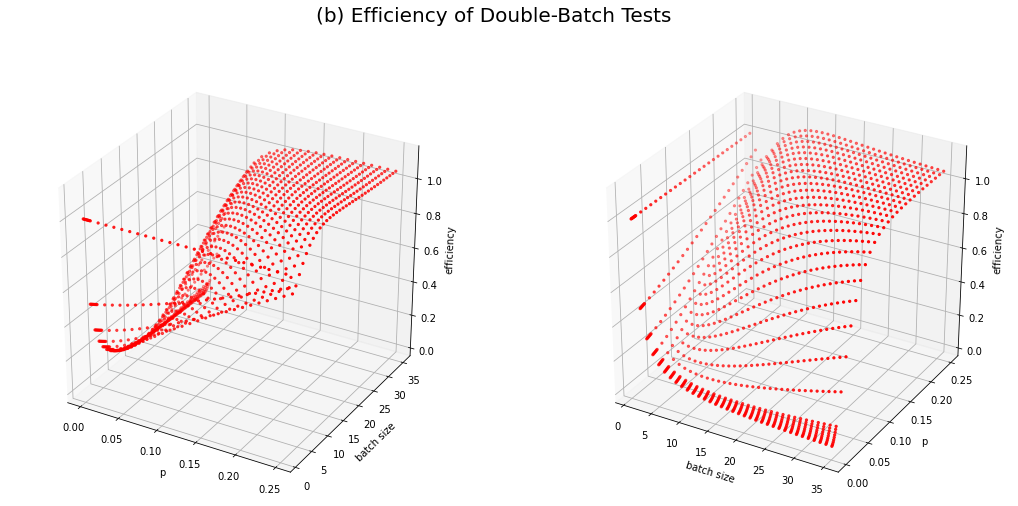

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [101]:
fig_3d = plt.figure(figsize = (18, 8))
ax1 = fig_3d.add_subplot(121, projection = '3d')

x = df.p
y = df.n_num
z = df.rates

ax1.scatter(x, y, z, c = 'r', marker = '.')

ax1.set_xlabel('p')
ax1.set_ylabel('batch size')
ax1.set_zlabel('efficiency')

ax2 = fig_3d.add_subplot(122, projection = '3d')
ax2.scatter(df.n_num, df.p, z, c = 'r', marker = '.')
ax2.set_xlabel('batch size')
ax2.set_ylabel('p')
ax2.set_zlabel('efficiency')

fig_3d.suptitle('(b) Efficiency of Double-Batch Tests', fontsize = 20)
plt.show()
fig_3d.savefig('expected_rate_seq_tests.eps')

In [145]:
def infection_rate_on_negative_batch(p,batch_size,typeII_error, typeI_error):
    temp_norm = (1-typeI_error) * (1-p) ** (batch_size)
    temp_denorm = temp_norm + typeII_error * (1-(1-p) ** batch_size)
    q_temp = np.power((temp_norm/temp_denorm),(1/batch_size))
    return 1-q_temp
    

In [146]:
infection_rate_on_negative_batch(0.05, 6, 0.15, 0.01)

0.00882145724888772

In [1]:
import batch_test_kit as btk
import pandas as pd
import numpy as np

In [10]:
btk.one_batch_test_int_solver(0.002 )

23

In [13]:
infection_rate_on_negative_batch(.01,11,0.15,0.01)

0.001594776213398319

In [2]:
subject_list = pd.Series(np.random.binomial(size = 2000, n = 1, p = 0.05))
subject_list

0       0
1       0
2       0
3       0
4       0
       ..
1995    0
1996    0
1997    0
1998    0
1999    0
Length: 2000, dtype: int64

In [4]:
result = btk.conventional_test(subject_list, 0.15, 0.01, 1)

In [2]:
import batch_test_kit as btk
import numpy as np
import pandas as pd

In [21]:
df = btk.repeat_result(100, 100000, 0.03, 7, 0.15, 0.01, 3)

In [27]:
3000/8940

0.33557046979865773

In [22]:
df.mean()

accuracy                  0.997448
precision                 0.999396
recall                    0.915461
f1                        0.955582
total_consump         62259.750000
individual_consump    26735.430000
dtype: float64

In [23]:
df.std()

accuracy                0.000159
precision               0.000485
recall                  0.005067
f1                      0.002757
total_consump         760.290088
individual_consump    568.628605
dtype: float64

In [40]:
subject_list = pd.Series(np.random.binomial(size = 2000, n = 1, p = 0.05))
temp = list(chunkbatch(subject_list, 11))[1]
neg_test_result = pd.Series([], dtype = int)
neg_test_result = neg_test_result.append(temp)
neg_test_result

11    0
12    0
13    0
14    1
15    0
16    0
17    0
18    0
19    0
20    0
21    0
dtype: int64

In [89]:
subject_list = pd.Series(np.random.binomial(size = 1000, n = 1, p = 0.05))
neg_test_result = pd.Series([], dtype = int)
for i in list(chunkbatch(subject_list, 6)):
    if 1 in set(i):
        if btk.classification(1, typeII_error = 0.15, typeI_error = 0.01) == 1:
            continue
        else:
            neg_test_result = neg_test_result.append(i)
    else:
        if btk.classification(0, typeII_error = 0.15, typeI_error = 0.01) == 0:
            neg_test_result = neg_test_result.append(i)
        else:
            continue
print(len(neg_test_result),np.mean(neg_test_result))


694 0.005763688760806916


In [64]:
infection_rate_on_negative_batch(0.05, 11, 0.15, 0.01)

0.009835882704819943

In [102]:
def infection_negative_batch(subject_list, batch_size, typeII_error, typeI_error):
    """
    To do
    """
    neg_test_result = pd.Series([], dtype = int)
    for i in list(chunkbatch(subject_list, batch_size)):
        if 1 in set(i):
            if btk.classification(1, typeII_error = 0.15, typeI_error = 0.01) == 1:
                continue
            else:
                neg_test_result = neg_test_result.append(i)
        else:
            if btk.classification(0, typeII_error = 0.15, typeI_error = 0.01) == 0:
                neg_test_result = neg_test_result.append(i)
            else:
                continue

    return (len(neg_test_result), np.mean(neg_test_result))


In [121]:
infection_rate,neg_test_no = np.zeros(500),np.zeros(500)
for i in range(500):
    subject_list = pd.Series(np.random.binomial(size = 1000, n = 1, p = 0.05))
    neg_test_no[i], infection_rate[i] = infection_negative_batch(subject_list, 6, 0.15, 0.01)


In [139]:
subject_lists =[pd.Series(np.random.binomial(size = 1000, n = 1, p = 0.05)) for _ in range(1000)]
temp = [infection_negative_batch(i, 6, 0.15, 0.01) for i in subject_lists]

In [140]:
np.array(temp).mean(axis = 0)

array([7.67528000e+02, 9.77822744e-03])

In [122]:
print(neg_test_no.mean(), neg_test_no.std(),infection_rate.mean(), infection_rate.std())

768.204 31.872470629055414 0.00990360814436 0.0039883675340445755


In [105]:
infection_rate_on_negative_batch(0.05, 6, 0.15, 0.01)

0.00882145724888772

In [107]:
0.013 - 0.0096

0.0034000000000000002

In [108]:
0.0088 - 0.0096

-0.0007999999999999986

In [148]:
temp = btk.repeat_comparison(100, 2, 0.01, typeI_error = 0.01)


In [165]:
temp = [btk.repeat_comparison(100, i, 0.01, n_population = 1000, typeI_error = 0.01).mean() for i in range(2,20)]

In [226]:
def data_frame_plot(num_repeat, p, n_population = 1000, typeII_error = 0.15, typeI_error = 0.01, n_repeat = 1):
    temp = [btk.repeat_comparison(num_repeat, i, p, n_population,
    typeII_error, typeI_error, n_repeat).mean() for i in range(2,20)]
    accuracy = [i[0] for i in temp]
    precision = [i[1] for i in temp]
    recall =  [i[2] for i in temp]
    f1 = [i[3] for i in temp]  
    test_kit_comsumption = [(i[8] + 1000) for i in temp]
    batch_size = list(range(2, 20))
    df = pd.DataFrame(list(zip(batch_size, accuracy, precision, recall, f1, test_kit_comsumption)), 
    columns = ['batch size','accuracy', 'ppv', 'sensitivity', 'f1', 'comsumptions' ])
    return df

In [227]:
temp_005 = data_frame_plot(100, 0.05)


In [230]:
df_1

Accuracy_Batch  Precision_Batch  Recall_Batch  f1_Batch  Accuracy_Con  \
0            0.959         0.966387      0.756579  0.848708         0.974   
0            0.953         0.990909      0.703226  0.822642         0.977   
0            0.963         0.920792      0.762295  0.834081         0.975   
0            0.947         0.941176      0.708861  0.808664         0.969   
0            0.965         0.946154      0.814570  0.875445         0.963   
..             ...              ...           ...       ...           ...   
0            0.957         0.963964      0.732877  0.832685         0.970   
0            0.958         0.920635      0.783784  0.846715         0.974   
0            0.951         0.952830      0.696552  0.804781         0.966   
0            0.953         0.943548      0.745223  0.832740         0.969   
0            0.961         0.972222      0.744681  0.843373         0.968   

    Precision_Con  Recall_Con    f1_Con  Test_Num_Difference  
0        0.937500    0.888158  0.912162                 -227  
0        0.958333    0.890323  0.923077                 -217  
0        0.900826    0.893443  0.897119                 -239  
0        0.937931    0.860759  0.897690                 -217  
0        0.890411    0.860927  0.875421                 -162  
..            ...         ...       ...                  ...  
0        0.908451    0.883562  0.895833                 -228  
0        0.962121    0.858108  0.907143                 -118  
0        0.944000    0.813793  0.874074                 -140  
0        0.956522    0.840764  0.894915                 -206  
0        0.929134    0.836879  0.880597                 -216  

[100 rows x 9 columns]

In [228]:
temp_005

batch size  accuracy       ppv  sensitivity        f1  comsumptions
0            2   0.98529  0.986224     0.717422  0.828308        592.82
1            3   0.98548  0.976811     0.720155  0.827208        459.36
2            4   0.98543  0.969616     0.733721  0.833795        417.40
3            5   0.98452  0.961518     0.719446  0.820921        397.90
4            6   0.98437  0.952470     0.728379  0.823698        404.02
5            7   0.98353  0.941970     0.720114  0.814325        406.73
6            8   0.98344  0.928764     0.733064  0.817735        427.24
7            9   0.98386  0.925386     0.729495  0.813697        431.64
8           10   0.98375  0.927235     0.732189  0.816433        446.50
9           11   0.98290  0.918802     0.722500  0.806193        463.45
10          12   0.98213  0.914813     0.715579  0.800707        480.96
11          13   0.98305  0.908652     0.730141  0.807710        498.44
12          14   0.98246  0.897586     0.734001  0.805196        515.64
13          15   0.98202  0.896619     0.714714  0.793762        516.15
14          16   0.98274  0.897891     0.734517  0.805706        537.00
15          17   0.98163  0.889782     0.722593  0.795062        554.42
16          18   0.98118  0.880082     0.728954  0.795664        580.46
17          19   0.98136  0.885775     0.722496  0.792959        588.80

In [229]:
temp_010 = data_frame_plot(100, 0.10)
temp_015 = data_frame_plot(100, 0.15)
temp_020 = data_frame_plot(100, 0.20)

In [166]:
temp = [btk.repeat_comparison(100, i, 0.01, n_population = 1000, typeI_error = 0.01).mean() for i in range(2,20)]
accuracy = [i[0] for i in temp]
precision = [i[1] for i in temp]
recall =  [i[2] for i in temp]
f1 = [i[3] for i in temp]  
test_kit_comsumption = [(i[8] + 1000) for i in temp]

In [171]:
batch_size = list(range(2, 20))

In [172]:
df = pd.DataFrame(
    list(zip(batch_size, accuracy, precision, recall, f1, test_kit_comsumption)), 
    columns = ['batch size','accuracy', 'ppv', 'sensitivity', 'f1', 'comsumptions' ]
)

In [173]:
df

batch size  accuracy       ppv  sensitivity        f1  comsumptions
0            2   0.99674  0.978586     0.702825  0.804943        527.64
1            3   0.99701  0.968361     0.719540  0.817150        368.14
2            4   0.99707  0.958939     0.725800  0.817085        289.36
3            5   0.99700  0.965250     0.717958  0.814837        251.40
4            6   0.99653  0.924671     0.699457  0.786349        226.54
5            7   0.99689  0.948509     0.720910  0.807190        207.94
6            8   0.99701  0.916125     0.745463  0.809530        198.36
7            9   0.99669  0.929393     0.737142  0.810525        193.21
8           10   0.99611  0.906901     0.692197  0.774244        191.80
9           11   0.99603  0.897372     0.717988  0.787857        193.84
10          12   0.99634  0.886135     0.728487  0.789568        188.20
11          13   0.99646  0.908757     0.713608  0.786321        186.39
12          14   0.99586  0.860896     0.725725  0.776373        197.18
13          15   0.99613  0.861862     0.732607  0.783070        195.20
14          16   0.99641  0.874370     0.739140  0.790241        192.76
15          17   0.99572  0.852358     0.707731  0.763150        199.55
16          18   0.99547  0.830945     0.690687  0.740239        201.82
17          19   0.99543  0.833248     0.713864  0.754364        213.92

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


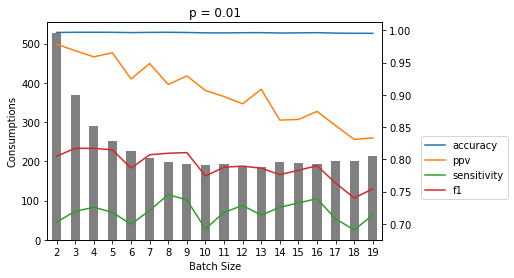

In [212]:
ax = df['comsumptions'].plot(kind = 'bar', color = 'grey')
df[['accuracy', 'ppv', 'sensitivity', 'f1']].plot(secondary_y = True, xlim = ax.get_xlim(), ax = ax, legend = False).legend(bbox_to_anchor = (1.1, 0.5))
ax.set_xticklabels(df['batch size'])
ax.set_xlabel('Batch Size')
ax.set_ylabel('Consumptions')
ax.set_title('p = 0.01')
ax.figure.savefig('p=0.01.eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


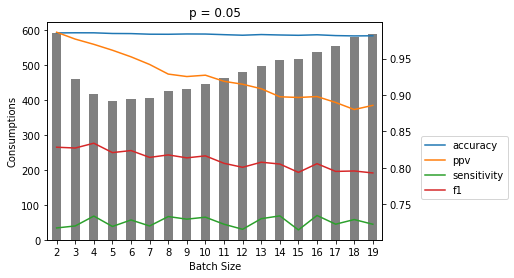

In [231]:
ax = temp_005['comsumptions'].plot(kind = 'bar', color = 'grey')
temp_005[['accuracy', 'ppv', 'sensitivity', 'f1']].plot(secondary_y = True, xlim = ax.get_xlim(), ax = ax, legend = False).legend(bbox_to_anchor = (1.1, 0.5))
ax.set_xticklabels(df['batch size'])
ax.set_xlabel('Batch Size')
ax.set_ylabel('Consumptions')
ax.set_title('p = 0.05')
ax.figure.savefig('p=0.05.eps',bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


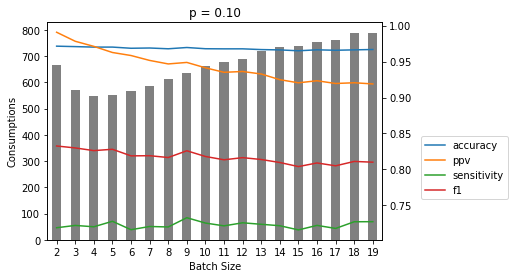

In [232]:
ax = temp_010['comsumptions'].plot(kind = 'bar', color = 'grey')
temp_010[['accuracy', 'ppv', 'sensitivity', 'f1']].plot(secondary_y = True, xlim = ax.get_xlim(), ax = ax, legend = False).legend(bbox_to_anchor = (1.1, 0.5))
ax.set_xticklabels(df['batch size'])
ax.set_xlabel('Batch Size')
ax.set_ylabel('Consumptions')
ax.set_title('p = 0.10')
ax.figure.savefig('p=0.10.eps',bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


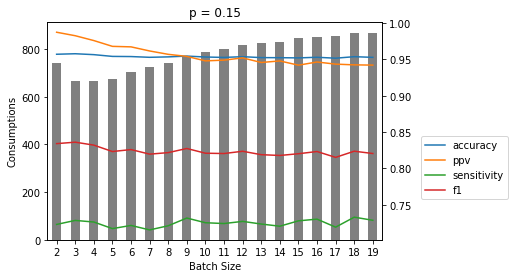

In [233]:
ax = temp_015['comsumptions'].plot(kind = 'bar', color = 'grey')
temp_015[['accuracy', 'ppv', 'sensitivity', 'f1']].plot(secondary_y = True, xlim = ax.get_xlim(), ax = ax, legend = False).legend(bbox_to_anchor = (1.1, 0.5))
ax.set_xticklabels(df['batch size'])
ax.set_xlabel('Batch Size')
ax.set_ylabel('Consumptions')
ax.set_title('p = 0.15')
ax.figure.savefig('p=0.15.eps',bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


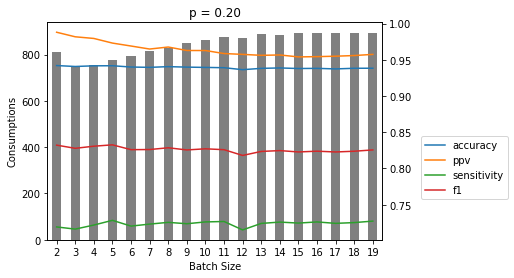

In [234]:
ax = temp_020['comsumptions'].plot(kind = 'bar', color = 'grey')
temp_020[['accuracy', 'ppv', 'sensitivity', 'f1']].plot(secondary_y = True, xlim = ax.get_xlim(), ax = ax, legend = False).legend(bbox_to_anchor = (1.1, 0.5))
ax.set_xticklabels(df['batch size'])
ax.set_xlabel('Batch Size')
ax.set_ylabel('Consumptions')
ax.set_title('p = 0.20')
ax.figure.savefig('p=0.20.eps',bbox_inches='tight')

In [223]:
temp_005

batch size  accuracy       ppv  sensitivity        f1  comsumptions
0            2   0.97146  0.638995     0.980839  0.772611        731.08
1            3   0.96671  0.605192     0.980105  0.746877        604.22
2            4   0.96164  0.567132     0.977250  0.716451        551.16
3            5   0.95582  0.532316     0.979811  0.688953        540.85
4            6   0.95013  0.510172     0.979941  0.669979        544.14
5            7   0.94470  0.481993     0.977637  0.644659        552.98
6            8   0.94194  0.452689     0.982353  0.618797        552.52
7            9   0.93655  0.445168     0.982147  0.611680        579.58
8           10   0.93329  0.433209     0.977600  0.599478        587.80
9           11   0.92997  0.413541     0.978725  0.580293        599.04
10          12   0.92671  0.402692     0.980929  0.569926        622.04
11          13   0.92322  0.386793     0.977437  0.553405        628.31
12          14   0.91921  0.378501     0.980970  0.545288        652.00
13          15   0.91592  0.377485     0.984604  0.544945        674.50
14          16   0.91276  0.365758     0.983992  0.532209        684.76
15          17   0.91371  0.364372     0.985709  0.531343        688.33
16          18   0.90665  0.346977     0.978952  0.511522        715.20
17          19   0.90513  0.343583     0.984609  0.508336        721.59

In [235]:
temp_005_rep2 = data_frame_plot(100, 0.05, n_population= 1000, typeII_error = 0.15, typeI_error = 0.01, n_repeat = 2)

In [237]:
temp_001_rep2 = data_frame_plot(100, 0.01, n_population= 1000, typeII_error = 0.15, typeI_error = 0.01, n_repeat = 2)
temp_010_rep2 = data_frame_plot(100, 0.10, n_population= 1000, typeII_error = 0.15, typeI_error = 0.01, n_repeat = 2)
temp_015_rep2 = data_frame_plot(100, 0.15, n_population= 1000, typeII_error = 0.15, typeI_error = 0.01, n_repeat = 2)
temp_020_rep2 = data_frame_plot(100, 0.20, n_population= 1000, typeII_error = 0.15, typeI_error = 0.01, n_repeat = 2)

In [241]:
temp_005_rep2

batch size  accuracy       ppv  sensitivity        f1  comsumptions
0            2   0.99095  0.988041     0.828306  0.899968       1112.80
1            3   0.99025  0.973106     0.829299  0.894558        824.66
2            4   0.98938  0.960176     0.824668  0.886187        699.64
3            5   0.98948  0.959937     0.825015  0.886230        635.15
4            6   0.98917  0.943850     0.830688  0.882543        607.00
5            7   0.98865  0.938261     0.829230  0.879446        594.89
6            8   0.98905  0.937617     0.838211  0.884158        592.08
7            9   0.98798  0.924181     0.826201  0.871250        598.47
8           10   0.98739  0.918039     0.828373  0.869574        605.90
9           11   0.98759  0.918205     0.825807  0.867895        613.25
10          12   0.98745  0.903897     0.832888  0.865748        619.76
11          13   0.98666  0.901601     0.822517  0.858994        639.85
12          14   0.98686  0.900411     0.823496  0.858762        646.12
13          15   0.98627  0.893232     0.827613  0.858108        667.20
14          16   0.98633  0.887811     0.828636  0.855664        673.84
15          17   0.98653  0.896587     0.833059  0.861980        697.17
16          18   0.98591  0.880930     0.824357  0.850486        704.04
17          19   0.98590  0.880375     0.833378  0.855070        726.41

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


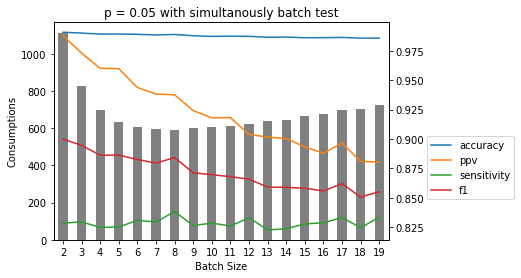

In [242]:
ax = temp_005_rep2['comsumptions'].plot(kind = 'bar', color = 'grey')
temp_005_rep2[['accuracy', 'ppv', 'sensitivity', 'f1']].plot(secondary_y = True, xlim = ax.get_xlim(), ax = ax, legend = False).legend(bbox_to_anchor = (1.1, 0.5))
ax.set_xticklabels(df['batch size'])
ax.set_xlabel('Batch Size')
ax.set_ylabel('Consumptions')
ax.set_title('p = 0.05 with simultanously batch test')
ax.figure.savefig('p=0.05_rep_2.eps',bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


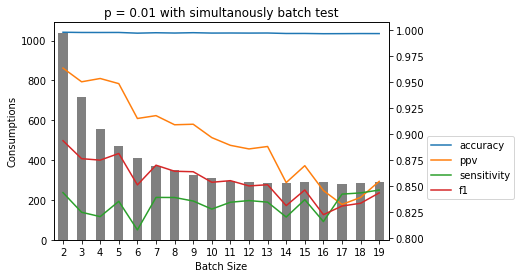

In [243]:
ax = temp_001_rep2['comsumptions'].plot(kind = 'bar', color = 'grey')
temp_001_rep2[['accuracy', 'ppv', 'sensitivity', 'f1']].plot(secondary_y = True, xlim = ax.get_xlim(), ax = ax, legend = False).legend(bbox_to_anchor = (1.1, 0.5))
ax.set_xticklabels(df['batch size'])
ax.set_xlabel('Batch Size')
ax.set_ylabel('Consumptions')
ax.set_title('p = 0.01 with simultanously batch test')
ax.figure.savefig('p=0.01_rep_2.eps',bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


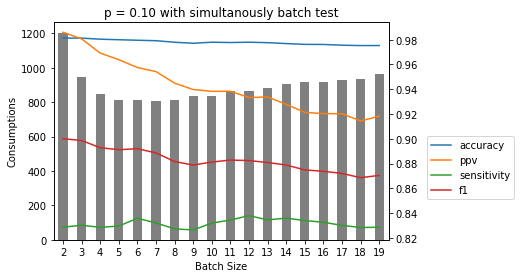

In [244]:
ax = temp_010_rep2['comsumptions'].plot(kind = 'bar', color = 'grey')
temp_010_rep2[['accuracy', 'ppv', 'sensitivity', 'f1']].plot(secondary_y = True, xlim = ax.get_xlim(), ax = ax, legend = False).legend(bbox_to_anchor = (1.1, 0.5))
ax.set_xticklabels(df['batch size'])
ax.set_xlabel('Batch Size')
ax.set_ylabel('Consumptions')
ax.set_title('p = 0.10 with simultanously batch test')
ax.figure.savefig('p=0.10_rep_2.eps',bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


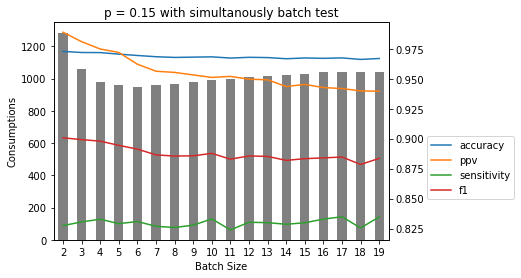

In [245]:
ax = temp_015_rep2['comsumptions'].plot(kind = 'bar', color = 'grey')
temp_015_rep2[['accuracy', 'ppv', 'sensitivity', 'f1']].plot(secondary_y = True, xlim = ax.get_xlim(), ax = ax, legend = False).legend(bbox_to_anchor = (1.1, 0.5))
ax.set_xticklabels(df['batch size'])
ax.set_xlabel('Batch Size')
ax.set_ylabel('Consumptions')
ax.set_title('p = 0.15 with simultanously batch test')
ax.figure.savefig('p=0.15_rep_2.eps',bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


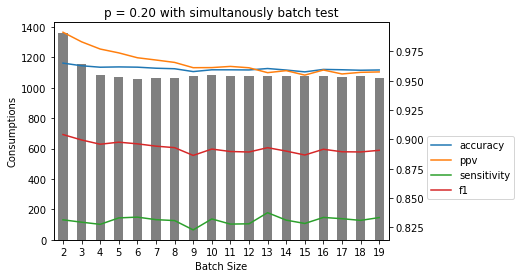

In [246]:
ax = temp_020_rep2['comsumptions'].plot(kind = 'bar', color = 'grey')
temp_020_rep2[['accuracy', 'ppv', 'sensitivity', 'f1']].plot(secondary_y = True, xlim = ax.get_xlim(), ax = ax, legend = False).legend(bbox_to_anchor = (1.1, 0.5))
ax.set_xticklabels(df['batch size'])
ax.set_xlabel('Batch Size')
ax.set_ylabel('Consumptions')
ax.set_title('p = 0.20 with simultanously batch test')
ax.figure.savefig('p=0.20_rep_2.eps',bbox_inches='tight')

In [5]:
subject_list = pd.Series(np.random.binomial(size = 1000, n = 1, p = 0.05))

In [8]:
subject_list

0      0
1      0
2      1
3      0
4      0
      ..
995    0
996    0
997    0
998    0
999    0
Length: 1000, dtype: int64

In [96]:
temp1_id = pd.Series(np.arange(len(subject_list)))
temp1_df = pd.concat([temp_id, subject_list], axis = 1)
temp1_df.columns = ['id', 'results']

In [107]:
for i in list(btk.chunkbatch(temp1_df, 100)):
    if 1 in set(i['results']):
        if btk.classification(1, typeII_error = 0.15, typeI_error = 0.01) == 1:
            temp_id = i['id']
            positive_batch = [btk.classification(j, typeII_error = 0.15, typeI_error = 0.01) for j in i['results']]
            temp_batch = pd.Series(positive_batch)
            temp_df = pd.concat([temp_id, temp_batch],
            axis = 1, ignore_index = True)
            temp_df.columns = ['id', 'preds']


In [5]:
import batch_test_kit as btk

In [31]:
subject_df = pd.DataFrame(np.random.binomial(size = 1000, n = 1, p = 0.15), columns = ['subject'])

In [127]:
btk.one_batch_test_int_solver(0.033)

6

In [124]:
neg_batch, pos_batch = btk.neg_pos_batch_split(subject_df, batch_size = 3, typeII_error = 0.15, typeI_error = 0.01)

In [126]:
np.mean(neg_batch)

subject    0.033926
dtype: float64

In [128]:
neg_batch_1, pos_batch_1 = btk.neg_pos_batch_split(neg_batch, batch_size = 6, typeII_error = 0.15, typeI_error = 0.01)

In [97]:
print(len(neg_batch_1), np.mean(neg_batch_1), len(pos_batch_1), np.mean(pos_batch_1))

676 subject    0.002959
dtype: float64 66 subject    0.075758
dtype: float64


In [129]:
pos_batch.append(pos_batch_1)

subject
0          0
1          0
2          1
3          1
4          0
..       ...
994        0
995        0
996        1
997        0
998        0

[459 rows x 1 columns]

In [130]:
temp, num = btk.conventional_test(pos_batch['subject'], typeII_error=0.15, typeI_error= 0.01)

In [131]:
temp = pd.DataFrame(temp, columns = ['subject'])

In [132]:
neg_batch_1['subject'] = 0

In [133]:
test = pd.concat([temp, neg_batch], axis = 0)
test.sort_index(inplace = True)

subject    0.988
dtype: float64

In [30]:
np.mean(pos_batch['subject'].apply(btk.classification,args = (0.15, 0.01)) == pos_batch['subject'])

0.9633333333333334

In [31]:
neg_batch_1, pos_batch_1 = btk.neg_pos_batch_split(neg_batch, 20, 0.15, 0.01)

In [14]:
np.mean(pos_batch_1['subject'])

0.0775

In [33]:
np.mean(neg_batch_1)

subject    0.002941
dtype: float64

In [34]:
np.mean(pos_batch)

subject    0.268333
dtype: float64

In [44]:
neg_batch_2, pos_batch_2 = btk.neg_pos_batch_split(pos_batch, 4, 0.15, 0.01)

In [45]:
np.mean(neg_batch_2)

subject    0.159091
dtype: float64

In [46]:
np.mean(pos_batch_2)

subject    0.287109
dtype: float64

In [120]:
precision_score(y_true = subject_df, y_pred  = test)
recall_score(y_true = subject_df, y_pred = test)
f1_score(y_true = subject_df, y_pred = test)

0.8749999999999999

In [121]:
print(precision_score(y_true = subject_df, y_pred  = test),
recall_score(y_true = subject_df, y_pred = test),
f1_score(y_true = subject_df, y_pred = test))


0.9333333333333333 0.8235294117647058 0.8749999999999999


In [2]:
btk.infection_rate_on_negative_batch(0.01, 32, 0.15, 0.01)

0.001976327594960294

In [5]:
btk.one_batch_test_solver(0.001, 0.15, 0.01)

2.0

In [2]:
import batch_test_kit as btk

In [17]:
typeII_error = 0.15
typeI_error = 0.01
q = 1- 0.001 # To consistent with the notation of our document
func = lambda n : n*q**(n/2)-(-(1-typeII_error - typeI_error)*np.log(q))**(-1/2)
fsolve(func, 10)

array([35.105784])

In [15]:
func(9)

nan

In [5]:
btk.one_batch_test_int_solver(0.01, 0.1,  0.01)

11

In [5]:
btk.one_batch_test_int_solver(0.05, 0.15, 0.01)

6

In [13]:
btk.one_batch_test_int_solver(0.05, 0.15, 0.01)
subject_df = pd.DataFrame(np.random.binomial(size = 1000, n = 1, p = 0.5), columns = ['subject'])

In [27]:
neg1, pos1 = btk.neg_pos_batch_split(subject_df,6, 0.15, 0.01)

In [2]:
repeat = 100
neg_length = np.zeros(repeat)
neg_p = np.zeros(repeat)
pos_length = np.zeros(repeat)
pos_p = np.zeros(repeat)
con = np.zeros(repeat)

for i in range(repeat):
    subject_df = pd.DataFrame(np.random.binomial(size = 1000, n = 1, p = 0.05), columns = ['subject'])
    neg_temp, pos_temp, consumption = btk.neg_pos_batch_split(subject_df, 6, 0.15, 0.01)
    neg_length[i] = len(neg_temp)
    neg_p[i] = np.mean(neg_temp)
    pos_length[i] = len(pos_temp)
    pos_p[i] = np.mean(pos_temp)
    con[i] = consumption

array([167., 167., 167., 167., 167., 167., 167., 167., 167., 167., 167.,
       167., 167., 167., 167., 167., 167., 167., 167., 167., 167., 167.,
       167., 167., 167., 167., 167., 167., 167., 167., 167., 167., 167.,
       167., 167., 167., 167., 167., 167., 167., 167., 167., 167., 167.,
       167., 167., 167., 167., 167., 167., 167., 167., 167., 167., 167.,
       167., 167., 167., 167., 167., 167., 167., 167., 167., 167., 167.,
       167., 167., 167., 167., 167., 167., 167., 167., 167., 167., 167.,
       167., 167., 167., 167., 167., 167., 167., 167., 167., 167., 167.,
       167., 167., 167., 167., 167., 167., 167., 167., 167., 167., 167.,
       167.])

In [31]:
print(np.mean(neg_length), np.mean(neg_p), np.mean(pos_length), np.mean(pos_p))

770.96 0.010197044362289152 229.04 0.18393143679476956


In [32]:
btk.infection_rate_on_negative_batch(0.05,6, 0.15, 0.01)

0.009772277425369506

In [33]:
btk.infection_rate_on_positive_batch(0.05,6, 0.15, 0.01)

0.18277776557616718

In [16]:
np.mean(pos1)

subject    0.225941
dtype: float64

In [17]:
btk.infection_rate_on_negative_batch(0.05, 6, 0.15, 0.01)

0.009772277425369506

In [18]:
btk.infection_rate_on_positive_batch(0.05, 6, 0.15, 0.01)

0.18277776557616718

In [11]:
btk.infection_rate_on_negative_batch(0.05, 6, 0.15, 0.01)

0.009772277425369506

In [20]:
len(pos1)

478

In [14]:
test = {'data': subject_df,
           'nb_num': 0,
           'pb_num': 0}

In [5]:
def helpfunction(subject_df, p, batch_size ,typeII_error, typeI_error):
    temp0, temp1, temp_con = btk.neg_pos_batch_split(subject_df,batch_size,typeII_error, typeI_error)
    p0 = btk.infection_rate_on_negative_batch(p, batch_size, typeII_error, typeI_error)
    p1 = btk.infection_rate_on_positive_batch(p, batch_size, typeII_error, typeI_error)
    n0= btk.one_batch_test_int_solver(p0, typeII_error, typeI_error)
    n1 = btk.one_batch_test_int_solver(p1, typeII_error, typeI_error)
    return(temp0, temp1, temp_con, p0, p1, n0, n1)

In [233]:
temp_list = []
neg_list = []
temp = {'data': subject_df,
       'NB_Num': 0,
       'PB_Num': 0,
       'p': 0.05,
       'batch_size': 6}
temp_list.append(temp)
new_list = []
for i in temp_list:
    temp0, temp1, temp_con, p0, p1, n0, n1 = helpfunction(i['data'], i['p'], i['batch_size'],
                                                                    typeII_error = 0.15, typeI_error = 0.01)
    temp0 = {'data': temp0,
            'NB_Num': i['NB_Num'] + 1,
            'PB_Num': i['PB_Num'],
            'p': p0,
            'batch_size': n0}
    temp1 = {'data': temp1,
            'NB_Num': i['NB_Num'],
            'PB_Num': i['PB_Num'] + 1,
            'p': p1,
            'batch_size': n1}
    if temp0['NB_Num'] >= 3:
        neg_list.append(temp0)
    else:
        new_list.append(temp0)
    if temp1['PB_Num'] >= 3:
        pos_list.append(temp1)
    else:
        new_list.append(temp1)
temp_list = new_list
new_list = []

In [239]:
neg_list = []
pos_list = []

In [240]:
for i in temp_list:
    temp0, temp1, temp_con, p0, p1, n0, n1 = helpfunction(i['data'], i['p'], i['batch_size'],
                                                                    typeII_error = 0.15, typeI_error = 0.01)
    temp0 = {'data': temp0,
            'NB_Num': i['NB_Num'] + 1,
            'PB_Num': i['PB_Num'],
            'p': p0,
            'batch_size': n0}
    temp1 = {'data': temp1,
            'NB_Num': i['NB_Num'],
            'PB_Num': i['PB_Num'] + 1,
            'p': p1,
            'batch_size': n1}
    if temp0['NB_Num'] >= 3:
        neg_list.append(temp0)
    else:
        new_list.append(temp0)
    if temp1['PB_Num'] >= 3:
        pos_list.append(temp1)
    else:
        new_list.append(temp1)
temp_list = new_list
new_list = []

In [334]:
def test(subject_df, p, batch_size, typeII_error, typeI_error):
    temp_list = []
    neg_list = []
    pos_list = []
    consum = 0
    temp = {'data': subject_df,
           'NB_Num': 0,
           'PB_Num': 0,
           'p': p,
           'batch_size': batch_size}
    temp_list.append(temp)
    new_list = []
    neg_df = pd.DataFrame(columns = ['subject'])
    pos_df = pd.DataFrame(columns = ['subject'])
    while len(temp_list) > 0:
        for i in temp_list:
            temp0, temp1, temp_con, p0, p1, n0, n1 = helpfunction(i['data'], i['p'], i['batch_size'],
                                                                            typeII_error = 0.15, typeI_error = 0.01)
            consum += temp_con 


            temp0 = {'data': temp0,
                    'NB_Num': i['NB_Num'] + 1,
                    'PB_Num': i['PB_Num'],
                    'p': p0,
                    'batch_size': n0}
            temp1 = {'data': temp1,
                    'NB_Num': i['NB_Num'],
                    'PB_Num': i['PB_Num'] + 1,
                    'p': p1,
                    'batch_size': n1}
            if temp0['NB_Num'] >= 3:
                neg_list.append(temp0)
            else:
                new_list.append(temp0)
            if temp1['PB_Num'] >= 3:
                pos_list.append(temp1)
            else:
                new_list.append(temp1)
        temp_list = new_list
        new_list = []
    for i in neg_list:
        neg_df = neg_df.append(i['data'])
    for i in pos_list:
        pos_df = pos_df.append(i['data'])
        
    neg_df['subject'] = 0
    individual_test, individual_con = btk.conventional_test(pos_df['subject'], typeII_error, typeI_error)
    pos_df['subject'] = individual_test
    consum += individual_con
    result = pd.concat([neg_df, pos_df])
    result.sort_index(inplace = True)
    return (result, consum, individual_con)
    
        

In [328]:
test(subject_df, 0.05, 6, 0.15, 0.01)

/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


(    subject
 0         0
 1         0
 2         0
 3         0
 4         0
 ..      ...
 95        0
 96        0
 97        0
 98        0
 99        0
 
 [100 rows x 1 columns],
 51,
 8)

In [3]:
temp = pd.DataFrame(columns = ['subject'])
#temp = temp.append(neg_list[1]['data'], ignore_index = True)
#temp = pd.concat([temp, neg_list[1]['data']], axis =0 )

In [285]:
temp.append(neg_list[3]['data'])

subject
75       0
76       0
77       0

In [325]:
temp.sort_index(ascending = True, inplace = True)
temp

subject
0        0
1        0
2        0
3        0
4        0
..     ...
95       0
96       0
97       0
98       0
99       0

[92 rows x 1 columns]

In [4]:
con = 0
p = 0.001
n = 10000
subject_df = pd.DataFrame(np.random.binomial(1, p,size = n ), columns = ['subject'])
temp0, temp1, temp_con, p0, p1, n0, n1 = helpfunction(subject_df, p, batch_size, typeII_error, typeI_error)
con = con + temp_con
# 0
temp00, temp01, temp_con, p00, p01, n00, n01 = helpfunction(temp0, p0, n0, typeII_error, typeI_error)
con = con + temp_con
# 1
temp10, temp11, temp_con, p10, p11, n10, n11 = helpfunction(temp1, p1, n1, typeII_error, typeI_error)
con = con + temp_con
# 00
temp000, temp001, temp_con, p000, p001, n000, n001 = helpfunction(temp00, p00, n00,typeII_error, typeI_error)
con = con + temp_con
# 01
temp010, temp011, temp_con, p010, p011, n010, n011 = helpfunction(temp01, p01, n01, typeII_error, typeI_error)
con = con + temp_con
# 10
temp100, temp101, temp_con, p100, p101, n100, n101 = helpfunction(temp10, p10, n10, typeII_error, typeI_error)
con = con + temp_con
# 11
temp110, temp111, temp_con, p110, p111, n110, n111 = helpfunction(temp11, p11, n11, typeII_error, typeI_error)
con = con + temp_con
# 001
temp0010, temp0011, tem_con, p0010, p0011, n0010, n0011 = helpfunction(temp001, p001, n001, typeII_error, typeI_error)
con = con + temp_con
# 010
temp0100, temp0101, temp_con, p0100, p0101, n0100, n0101 = helpfunction(temp010, p010, n010, typeII_error, typeI_error)
con = con + temp_con
# 011
temp0110, temp0111, temp_con, p0110, p0111, n0110, n0111 = helpfunction(temp011, p011, n011, typeII_error, typeI_error)
con += temp_con
# 100
temp1000, temp1001, temp_con, p1000, p1001, n1000, n1001 = helpfunction(temp100, p100, n100, typeII_error, typeI_error)
con += temp_con
# 101
temp1010, temp1011, temp_con, p1010, p1011, n1010, n1011 = helpfunction(temp101, p101, n101, typeII_error, typeI_error)
con += temp_con
# 110
temp1100, temp1101, temp_con, p1100, p1101, n1100, n1101 = helpfunction(temp110, p110, n110, typeII_error, typeI_error)
con += temp_con
# 0011
temp00110, temp00111, temp_con, p00110, p00111, n00110, n00111 = helpfunction(temp0011, p0011, n0011,typeII_error, typeI_error)
con += temp_con
# 0101
temp01010, temp01011, temp_con, p01010, p01011, n01010, n01011 = helpfunction(temp0101, p0101, n0101,typeII_error, typeI_error)
con += temp_con
# 0110
temp01100, temp01101, temp_con, p01100, p01101, n01100, n01101 = helpfunction(temp0110, p0110, n0110,typeII_error, typeI_error)
con += temp_con
# 1001
temp10010, temp10011, temp_con, p10010, p10011, n10010, n10011 = helpfunction(temp1001, p1001, n1001,typeII_error, typeI_error)
con += temp_con
# 1100
temp11000, temp11001, temp_con, p11000, p11001, n11000, n11001 = helpfunction(temp1100, p1100, n1100, typeII_error, typeI_error)
con += temp_con
# 1010
temp10100, temp10101, temp_con, p10100, p10101, n10100, n10101 = helpfunction(temp1010, p1010, n1010, typeII_error, typeI_error)
con += temp_con
#
neg_batch = pd.concat([temp000, temp0010, temp1000, temp0100,
                      temp00110, temp01010, temp01100, temp10010, temp11000, temp10100])
pos_batch = pd.concat([temp111, temp0111, temp1011, temp1101,
                      temp11001, temp10011, temp00111, temp01011, temp01101, temp10101])
neg_batch['subject'] = 0
temp_test, temp_con = btk.conventional_test(pos_batch['subject'], typeII_error, typeI_error)
pos_batch['subject'] = temp_test
con += temp_con
result = pd.concat([neg_batch, pos_batch])
result.sort_index(inplace = True)

NameError: name 'helpfunction' is not defined

In [330]:
def repeat_result(num_repeat,n_pop, p, batch_size, typeII_error, typeI_error):
    accuracy_tab = np.zeros(num_repeat)
    precision_tab = np.zeros(num_repeat)
    recall_tab = np.zeros(num_repeat)
    f1_tab = np.zeros(num_repeat)
    total_consump = np.zeros(num_repeat)
    individual_consump = np.zeros(num_repeat)
    for i in range(num_repeat):
        subject_df = pd.DataFrame(np.random.binomial(size = n_pop, n = 1,p = p), columns = ['subject'])
        result, con, temp_con = test(subject_df, p, batch_size, typeII_error, typeI_error)
        accuracy_tab[i] = np.mean(result == subject_df)
        precision_tab[i] = precision_score(y_true = subject_df, y_pred = result)
        recall_tab[i] = recall_score(y_true = subject_df, y_pred = result)
        f1_tab[i] = f1_score(y_true = subject_df, y_pred = result)
        total_consump[i] = con
        individual_consump[i] = temp_con
    df = pd.DataFrame({'accuracy': accuracy_tab, 
                   'precision': precision_tab, 
                   'recall': recall_tab, 
                   'f1': f1_tab, 
                   'total_consump': total_consump, 
                   'individual_consump': individual_consump})
    return df

In [339]:
neg_batch, pos_batch, consump, p0, p1, n0, n1 = helpfunction(subject_df, 0.0017, 27, 0.15, 0.01)

In [341]:
print(consump, p0, p1, n0, n1)

371 0.00026777722077148076 0.030283431032079432 67 7


In [345]:
num_repeat = 100
n_pop = 10000
p = 0.01
batch_size = btk.one_batch_test_int_solver(p, 0.15, 0.01)
typeII_error = 0.15
typeI_error = 0.01
accuracy_tab = np.zeros(num_repeat)
precision_tab = np.zeros(num_repeat)
recall_tab = np.zeros(num_repeat)
f1_tab = np.zeros(num_repeat)
total_consump = np.zeros(num_repeat)
individual_consump = np.zeros(num_repeat)
for i in range(num_repeat):
    subject_df = pd.DataFrame(np.random.binomial(size = n_pop, n = 1,p = p), columns = ['subject'])
    result, con, temp_con = test(subject_df, p, batch_size, typeII_error, typeI_error)
    accuracy_tab[i] = np.mean(result == subject_df)
    precision_tab[i] = precision_score(y_true = subject_df, y_pred = result)
    recall_tab[i] = recall_score(y_true = subject_df, y_pred = result)
    f1_tab[i] = f1_score(y_true = subject_df, y_pred = result)
    total_consump[i] = con
    individual_consump[i] = temp_con
df = pd.DataFrame({'accuracy': accuracy_tab, 
                   'precision': precision_tab, 
                   'recall': recall_tab, 
                   'f1': f1_tab, 
                   'total_consump': total_consump, 
                   'individual_consump': individual_consump})
df.mean()

/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


accuracy                 0.998009
precision                0.971845
recall                   0.827347
f1                       0.893270
total_consump         2308.750000
individual_consump     348.070000
dtype: float64

In [2]:
import batch_test_kit as btk

In [35]:
btk.one_batch_test_int_solver(0.01, 0.15, 0.01)



12

In [30]:
test1 = btk.repeat_result(100, 100000, 0.01, 12, 0.15, 0.01,  3, 0.3)
test1.mean()

accuracy                 0.998990
precision                0.998889
recall                   0.902948
f1                       0.948233
total_consump         3022.500000
individual_consump    1050.600000
dtype: float64

In [33]:
test1.std()

accuracy                0.000345
precision               0.003514
recall                  0.031199
f1                      0.017001
total_consump         129.540427
individual_consump     93.752867
dtype: float64

In [36]:
p = 0.001
num = btk.one_batch_test_int_solver(p, 0.15, 0.01)
test001 = btk.repeat_result(100,100000, p, num, 0.15, 0.01,  3, 0.3)

In [37]:
test001.mean()

accuracy                 0.999914
precision                0.998768
recall                   0.916952
f1                       0.955897
total_consump         7263.780000
individual_consump    1552.500000
dtype: float64

In [38]:
test001.std()

accuracy                0.000028
precision               0.003798
recall                  0.026730
f1                      0.014377
total_consump         257.133679
individual_consump    168.667775
dtype: float64

In [39]:
p = 0.03
num = btk.one_batch_test_int_solver(p, 0.15, 0.01)
test03 = btk.repeat_result(100,100000, p, num, 0.15, 0.01,  3, 0.3)

/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [47]:
test03.mean()

accuracy                  0.997496
precision                 0.999157
recall                    0.917276
f1                        0.956461
total_consump         63989.610000
individual_consump    32179.470000
dtype: float64

In [49]:
test03.std()

accuracy                0.000147
precision               0.000505
recall                  0.004783
f1                      0.002574
total_consump         695.792418
individual_consump    579.789224
dtype: float64

In [40]:
p = 0.05
num = btk.one_batch_test_int_solver(p, 0.15, 0.01)
test05 = btk.repeat_result(100,100000, p, num, 0.15, 0.01,  3, 0.3)

/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [50]:
test05.mean()

accuracy                  0.995817
precision                 0.999384
recall                    0.916732
f1                        0.956271
total_consump         85178.130000
individual_consump    43641.930000
dtype: float64

In [51]:
test05.std()

accuracy                0.000198
precision               0.000390
recall                  0.003957
f1                      0.002162
total_consump         729.056422
individual_consump    578.861060
dtype: float64

In [41]:
p = 0.05
num = btk.one_batch_test_int_solver(p, 0.15, 0.01)
test05_1 = btk.repeat_result(100,100000, p, num, 0.15, 0.01,  3, 1)

In [52]:
test05_1.mean()

accuracy                  0.995717
precision                 0.999414
recall                    0.915052
f1                        0.955369
total_consump         87237.390000
individual_consump    42252.900000
dtype: float64

In [53]:
test05_1.std()

accuracy                0.000212
precision               0.000351
recall                  0.004341
f1                      0.002358
total_consump         772.168439
individual_consump    580.741454
dtype: float64

In [42]:
p = 0.06
num = btk.one_batch_test_int_solver(p, 0.15, 0.01)
test06_1 = btk.repeat_result(100,100000, p, num, 0.15, 0.01,  3, 1)

In [43]:
p = 0.06
num = btk.one_batch_test_int_solver(p, 0.15, 0.01)
test06 = btk.repeat_result(100,100000, p, num, 0.15, 0.01,  3, 0.3)

In [44]:
p = 0.07
num = btk.one_batch_test_int_solver(p, 0.15, 0.01)
test07_1 = btk.repeat_result(100,100000, p, num, 0.15, 0.01,  3, 1)
test07 = btk.repeat_result(100,100000, p, num, 0.15, 0.01,  3, 0.3)

In [45]:
p = 0.08
num = btk.one_batch_test_int_solver(p, 0.15, 0.01)
test08_1 = btk.repeat_result(100,100000, p, num, 0.15, 0.01,  3, 1)
test08 = btk.repeat_result(100,100000, p, num, 0.15, 0.01,  3, 0.3)

In [46]:
p = 0.09
num = btk.one_batch_test_int_solver(p, 0.15, 0.01)
test09_1 = btk.repeat_result(100,100000, p, num, 0.15, 0.01,  3, 1)
test09 = btk.repeat_result(100,100000, p, num, 0.15, 0.01,  3, 0.3)

KeyboardInterrupt: 

In [ ]:
p = 0.1
num = btk.one_batch_test_int_solver(p, 0.15, 0.01)
test10_1 = btk.repeat_result(100,100000, p, num, 0.15, 0.01,  3, 1)
test10 = btk.repeat_result(100,100000, p, num, 0.15, 0.01,  3, 0.3)

In [97]:
p = 0.15
num = btk.one_batch_test_int_solver(p, 0.15, 0.01)
test15_1 = btk.repeat_result(10,1000, p, num, 0.15, 0.01,  3, 1)
test15 = btk.repeat_result(10,1000, p, num, 0.15, 0.01,  3, 0.3)

In [98]:
test15_1.mean()

accuracy                 0.985800
precision                0.998586
recall                   0.913194
f1                       0.953835
total_consump         1862.100000
individual_consump    1099.800000
dtype: float64

In [99]:
test15.mean()

accuracy                 0.990800
precision                0.999270
recall                   0.938304
f1                       0.967683
total_consump         1854.700000
individual_consump    1422.600000
dtype: float64

In [100]:
p = 0.20
num = btk.one_batch_test_int_solver(p, 0.15, 0.01)
test20_1 = btk.repeat_result(100,1000, p, num, 0.15, 0.01,  3, 1)
test20 = btk.repeat_result(100,1000, p, num, 0.15, 0.01,  3, 0.3)

In [102]:
test20.mean()

accuracy                 0.984980
precision                0.999626
recall                   0.924908
f1                       0.960673
total_consump         1998.930000
individual_consump    1450.440000
dtype: float64

In [103]:
test20_1.mean()

accuracy                 0.982100
precision                0.999361
recall                   0.911652
f1                       0.953386
total_consump         2208.100000
individual_consump    1379.760000
dtype: float64

In [96]:
test3 = btk.repeat_result(10, 1000, 0.01, 12, 0.15, 0.01,  3, 1)
test3.mean()

accuracy                0.999200
precision               1.000000
recall                  0.919156
f1                      0.956520
total_consump         275.200000
individual_consump     82.500000
dtype: float64

In [7]:
test1.std()

accuracy               0.004905
precision              0.002151
recall                 0.027484
f1                     0.015532
total_consump         90.767407
individual_consump    96.312512
dtype: float64

In [431]:
test2 = repeat_result(100, 10000, 0.001, 35, 0.15, 0.01)
test2.mean()

accuracy                0.999799
precision               0.955562
recall                  0.849064
f1                      0.894249
total_consump         625.160000
individual_consump     50.360000
dtype: float64

In [432]:
test2.std()

accuracy               0.000162
precision              0.066653
recall                 0.113359
f1                     0.074804
total_consump         48.597859
individual_consump    17.735726
dtype: float64

In [179]:
result, con, temp_con = test(subject_df, 0.02, 8, 0.15, 0.01)

In [357]:
btk.one_batch_test_int_solver(0.01, 0.15, 0.01)



12

In [342]:
con = 0
temp0, temp1, temp_con, p0, p1, n0, n1 = helpfunction(subject_df, p, batch_size, typeII_error, typeI_error)
con = con + temp_con
# 0
temp00, temp01, temp_con, p00, p01, n00, n01 = helpfunction(temp0, p0, n0, typeII_error, typeI_error)
con = con + temp_con

In [347]:
p000

0.00025748787429323637

In [351]:
np.mean(temp0010)

subject    0.010204
dtype: float64

In [356]:
p010

0.017154558496293975

In [344]:
p01

0.03018872423495908

In [173]:
subject_df = pd.DataFrame(np.random.binomial(size = 1000, n = 1, p = 0.02), columns = ['subject'])

In [359]:
p0

0.0016767958321220412

In [360]:
p1

0.08061708470140153

In [364]:
p10

0.045059236310005815

In [365]:
n0

27

In [366]:
p00

0.00026398257624865666

In [397]:
btk.infection_rate_on_negative_batch(0.0016767958321220412, 27,0.15, 0.01)

0.00026398257624865666

In [370]:
btk.infection_rate_on_negative_batch(0.05, 6,0.15, 0.01)

0.009772277425369506

In [378]:
btk.infection_rate_on_positive_batch(0.001677, 27, 0.15, 0.01)

0.030189565498958758

Suppose the infection rate is $p = 0.0017$, $\alpha = 0.01$, and $\beta = 0.15$ The infection rate on negative batch is 

In [388]:
p = 0.001677
q = 1- p
alpha = 0.01
beta = 0.15
n = 27
r = beta * (1 - q**n)/((1-alpha) * q**n + beta * (1- q **n))
p_new = p*r/(1-q**n)
p_new

0.0002640159472846638

In [392]:
p000

0.00025748787429323637

In [398]:
btk.one_batch_test_int_solver(0.00026398257624865666, 0.15, 0.01)



68

In [393]:
n000

69

In [389]:
((1-alpha) * q**n + beta * (1- q **n))

0.9527833548962749

In [387]:
btk.infection_rate_on_negative_batch(0.0017, 27, 0.15, 0.01)

0.00026777722077148076

In [409]:
btk.infection_rate_on_positive_batch(0.00026, 68, 0.15, 0.01)

0.008939195449686969

In [414]:
p010

0.017154558496293975

In [421]:
p0

0.02918460033946742

In [64]:
p = 0.1
typeII_error = 0.15
typeI_error = 0.01
batch_size = 12
subject_df = pd.DataFrame(np.random.binomial(size = 1000, n = 1, p = 0.01), columns = ['subject'])
con = 0
temp0, temp1, temp_con, p0, p1, n0, n1 = helpfunction(subject_df, p, batch_size, typeII_error, typeI_error)
con = con + temp_con
# 0
temp00, temp01, temp_con, p00, p01, n00, n01 = helpfunction(temp0, p0, n0, typeII_error, typeI_error)
con = con + temp_con
# 1
temp10, temp11, temp_con, p10, p11, n10, n11 = helpfunction(temp1, p1, n1, typeII_error, typeI_error)
con = con + temp_con
# 00
temp000, temp001, temp_con, p000, p001, n000, n001 = helpfunction(temp00, p00, n00,typeII_error, typeI_error)
con = con + temp_con
# 01
temp010, temp011, temp_con, p010, p011, n010, n011 = helpfunction(temp01, p01, n01, typeII_error, typeI_error)
con = con + temp_con
# 10
temp100, temp101, temp_con, p100, p101, n100, n101 = helpfunction(temp10, p10, n10, typeII_error, typeI_error)
con = con + temp_con
# 11
temp110, temp111, temp_con, p110, p111, n110, n111 = helpfunction(temp11, p11, n11, typeII_error, typeI_error)
con = con + temp_con
# 001
temp0010, temp0011, tem_con, p0010, p0011, n0010, n0011 = helpfunction(temp001, p001, n001, typeII_error, typeI_error)
con = con + temp_con
# 010
temp0100, temp0101, temp_con, p0100, p0101, n0100, n0101 = helpfunction(temp010, p010, n010, typeII_error, typeI_error)
con = con + temp_con
# 011
temp0110, temp0111, temp_con, p0110, p0111, n0110, n0111 = helpfunction(temp011, p011, n011, typeII_error, typeI_error)
con += temp_con
# 100
temp1000, temp1001, temp_con, p1000, p1001, n1000, n1001 = helpfunction(temp100, p100, n100, typeII_error, typeI_error)
con += temp_con
# 101
temp1010, temp1011, temp_con, p1010, p1011, n1010, n1011 = helpfunction(temp101, p101, n101, typeII_error, typeI_error)
con += temp_con
# 110
temp1100, temp1101, temp_con, p1100, p1101, n1100, n1101 = helpfunction(temp110, p110, n110, typeII_error, typeI_error)
con += temp_con
# 0011
temp00110, temp00111, temp_con, p00110, p00111, n00110, n00111 = helpfunction(temp0011, p0011, n0011,typeII_error, typeI_error)
con += temp_con
# 0101
temp01010, temp01011, temp_con, p01010, p01011, n01010, n01011 = helpfunction(temp0101, p0101, n0101,typeII_error, typeI_error)
con += temp_con
# 0110
temp01100, temp01101, temp_con, p01100, p01101, n01100, n01101 = helpfunction(temp0110, p0110, n0110,typeII_error, typeI_error)
con += temp_con
# 1001
temp10010, temp10011, temp_con, p10010, p10011, n10010, n10011 = helpfunction(temp1001, p1001, n1001,typeII_error, typeI_error)
con += temp_con
# 1100
temp11000, temp11001, temp_con, p11000, p11001, n11000, n11001 = helpfunction(temp1100, p1100, n1100, typeII_error, typeI_error)
con += temp_con
# 1010
temp10100, temp10101, temp_con, p10100, p10101, n10100, n10101 = helpfunction(temp1010, p1010, n1010, typeII_error, typeI_error)
con += temp_con
#
neg_batch = pd.concat([temp000, temp0010, temp1000, temp0100,
                      temp00110, temp01010, temp01100, temp10010, temp11000, temp10100])
pos_batch = pd.concat([temp111, temp0111, temp1011, temp1101,
                      temp11001, temp10011, temp00111, temp01011, temp01101, temp10101])
neg_batch['subject'] = 0
temp_test, temp_con = btk.conventional_test(pos_batch['subject'], typeII_error, typeI_error)
pos_batch['subject'] = temp_test
con += temp_con
result = pd.concat([neg_batch, pos_batch])
result.sort_index(inplace = True)

/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [102]:
subject_df = pd.DataFrame(np.random.binomial(size = 1000, n = 1, p = 0.2), columns = ['subject'])

In [113]:
p  = 0.2
typeI_error = 0.01
typeII_error = 0.15
repeat = 4
batch_size = 3
prob_clip = 1

In [114]:
temp_list = []
neg_list = []
pos_list = []
consum = 0
temp = {'data': subject_df,
       'NB_Num': 0,
       'PB_Num': 0,
       'p': p,
       'batch_size': batch_size}
temp_list.append(temp)
new_list = []
neg_df = pd.DataFrame(columns = ['subject'])
pos_df = pd.DataFrame(columns = ['subject'])
while len(temp_list) > 0:
    for i in temp_list:
        temp0, temp1, temp_con, p0, p1, n0, n1 = btk.helpfunction(i['data'], i['p'], i['batch_size'],
                                                                        typeII_error = 0.15, typeI_error = 0.01)
        temp0 = {'data': temp0,
                'NB_Num': i['NB_Num'] + 1,
                'PB_Num': i['PB_Num'],
                'p': p0,
                'batch_size': n0}
        temp1 = {'data': temp1,
                'NB_Num': i['NB_Num'],
                'PB_Num': i['PB_Num'] + 1,
                'p': p1,
                'batch_size': n1}
        if temp0['NB_Num'] >= 3:
            neg_list.append(temp0)
        else:
            new_list.append(temp0)
        if temp1['PB_Num'] >= 3 or temp1['p'] >= prob_clip:
            pos_list.append(temp1)
        else:
            new_list.append(temp1)
        consum += temp_con 
    temp_list = new_list
    new_list = []
for i in neg_list:
    neg_df = neg_df.append(i['data'])
for i in pos_list:
    pos_df = pos_df.append(i['data'])

neg_df['subject'] = 0
i = 0
temp_neg = pd.DataFrame(columns= ['subject'])
temp_pos = pd.DataFrame(columns= ['subject'])
individual_con = 0
individual_canidate = pos_df.copy()
while i < repeat:
    temp_test, temp_con = btk.conventional_test(individual_canidate['subject'], typeII_error, typeI_error, 1)
    temp_pos = pd.concat([temp_pos, pd.DataFrame(temp_test[temp_test == 1], 
                                                columns = ['subject'])])
    temp_neg = pd.DataFrame(temp_test[temp_test == 0], columns = ['subject'])
    individual_canidate  = temp_neg
    individual_con += temp_con
    i += 1
result = pd.concat([neg_df, temp_pos, temp_neg])    
result.sort_index(inplace = True)
result = result.astype('int')

/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [115]:
np.sum(result[result['subject'] == 1])

subject    169
dtype: int64

In [118]:
recall_score(y_true = subject_df, y_pred = result)

0.797979797979798

In [86]:
np.sum(subject_df[subject_df['subject'] == 1])

subject    10
dtype: int64

In [111]:
np.mean(result['subject'] == subject_df['subject'])

0.963

In [ ]:
def seq_test(subject_df, p, batch_size, typeII_error, typeI_error, repeat = 1, prob_clip = 1):
    """
    """
    temp_list = []
    neg_list = []
    pos_list = []
    consum = 0
    temp = {'data': subject_df,
           'NB_Num': 0,
           'PB_Num': 0,
           'p': p,
           'batch_size': batch_size}
    temp_list.append(temp)
    new_list = []
    neg_df = pd.DataFrame(columns = ['subject'])
    pos_df = pd.DataFrame(columns = ['subject'])
    while len(temp_list) > 0:
        for i in temp_list:
            temp0, temp1, temp_con, p0, p1, n0, n1 = helpfunction(i['data'], i['p'], i['batch_size'],
                                                                            typeII_error = 0.15, typeI_error = 0.01)
            temp0 = {'data': temp0,
                    'NB_Num': i['NB_Num'] + 1,
                    'PB_Num': i['PB_Num'],
                    'p': p0,
                    'batch_size': n0}
            temp1 = {'data': temp1,
                    'NB_Num': i['NB_Num'],
                    'PB_Num': i['PB_Num'] + 1,
                    'p': p1,
                    'batch_size': n1}
            if temp0['NB_Num'] >= 3:
                neg_list.append(temp0)
            else:
                new_list.append(temp0)
            if temp1['PB_Num'] >= 3 or temp1['p'] >= prob_clip:
                pos_list.append(temp1)
            else:
                new_list.append(temp1)
            consum += temp_con 
        temp_list = new_list
        new_list = []
    for i in neg_list:
        neg_df = neg_df.append(i['data'])
    for i in pos_list:
        pos_df = pos_df.append(i['data'])
        
    neg_df['subject'] = 0
    individual_test, individual_con = conventional_test(pos_df['subject'], typeII_error, typeI_error, repeat)
    pos_df['subject'] = individual_test
    consum += individual_con
    result = pd.concat([neg_df, pos_df])
    result.sort_index(inplace = True)
    return (result, consum, individual_con)

In [95]:
individual_con

120

In [50]:
test  = pd.DataFrame(test, columns = ['subject'])

In [51]:
temp = pd.DataFrame(columns= ['subject'])

In [52]:
temp = pd.concat([temp, test])

In [87]:
result, consum, _ = btk.seq_test(subject_df, 0.15,5,0.15,0.01,3,0.3)

In [89]:
result['subject']

0      0
1      0
2      0
3      0
4      0
      ..
995    0
996    0
997    0
998    0
999    0
Name: subject, Length: 1000, dtype: int64

In [91]:
btk.specificity_score(y_true=subject_df['subject'], y_pred = result['subject'])

0.996969696969697

In [209]:
confusion_matrix?

In [104]:
from sklearn.metrics import precision_score

In [111]:
type(result)

pandas.core.frame.DataFrame

In [122]:
from sklearn.metrics import f1_score

In [93]:
recall_score(result, subject_df)

0.75

In [11]:
def batch_test_eval(subject_df,p,batch_size, typeII_error = 0.15, 
               typeI_error = 0, repeat = 1, prob_clip = 1):
    """
    Given the subject df, batch size, type II error, and type I error, this function 
    gives the comparison between batch test and conventional test.

    Inputs:
        subject_list(list(int)): a dataframe of testers with columns = ['subject']
        batch_size(int): the size of batch size
        typeII_error(float): the prob to predict negative given the positive tester
        typeI_error(float): the prob to predict positive given the negative tester
        repeat(int):

    Outputs:
        (pd.Dataframe) a dataframe contains comparison between batch test and conventional
        test:
            Accuracy: accuracy for batch test
            Precision: precision for batch test
            Recall: recall for batch test
            f1: f1 scores for batch test
            consum: total consumption of testkit
            individual_con: individual test consumption
    """
    batch_pred, consum, individual_con = btk.seq_test(subject_df,p,batch_size,
                                                      typeII_error, typeI_error, 
                                                      repeat, prob_clip)
    # Batch_test
    accuracy = np.mean(batch_pred['subject'] == subject_df['subject'])
    precision = precision_score(y_true = subject_df, y_pred  = batch_pred)
    recall = recall_score(y_true = subject_df, y_pred = batch_pred)
    f1 = f1_score(y_true = subject_df, y_pred = batch_pred)
    specificity = btk.specificity_score(y_true=subject_df, y_pred = batch_pred)
    npv = btk.npv_score(y_true = subject_df, y_pred = batch_pred)
    
    
    df = pd.DataFrame({'Accuracy': [accuracy],
                       'Precision': [precision],
                       'Recall': [recall],
                       'specificity': [specificity],
                       'npv': [npv],
                       'f1': [f1],
                       'Consum': [consum],
                       'Individual_Con': [individual_con]
                        })
    return df

In [128]:
df = batch_test_eval(subject_df, 0.05, , 0.15, 0.01, 3, 1)
df

/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/Haoran 1/Desktop/Machine_Learning/batch_test_kit.py:296: RuntimeWarning: divide by zero encountered in double_scalars
  func = lambda batch_size: 1/batch_size + 1 - typeII_error -(1 - typeII_error - typeI_error)*(1-prevalence_rate)**batch_size


Accuracy  Precision    Recall  specificity       npv        f1  Consum  \
0     0.967   0.988166  0.843434     0.997506  0.962696  0.910082    1836   

   Individual_Con  
0             422

In [149]:
a,_ = btk.conventional_test(subject_df['subject'], 0.15, 0.01, 1)

In [202]:
from sklearn.metrics import confusion_matrix

In [10]:
def npv_score(y_pred, y_true):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn/(tn + fn)

In [9]:
def specificity_score(y_pred, y_true):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn/(tn + fp)

In [8]:
def conv_test_eval(subject_df,typeII_error = 0.15, 
               typeI_error = 0, repeat = 1):
    """
    Given the subject df, batch size, type II error, and type I error, this function 
    gives the comparison between batch test and conventional test.

    Inputs:
        subject_list(list(int)): a dataframe of testers with columns = ['subject']
        typeII_error(float): the prob to predict negative given the positive tester
        typeI_error(float): the prob to predict positive given the negative tester
        repeat(int):

    Outputs:
        (pd.Dataframe) a dataframe contains comparison between batch test and conventional
        test:
            Accuracy: accuracy for batch test
            Precision: precision for batch test
            Recall: recall for batch test
            f1: f1 scores for batch test
            consum: total consumption of testkit
            individual_con: individual test consumption
    """
    batch_pred, consum = btk.conventional_test(subject_df['subject'],
                                                      typeII_error, typeI_error, 
                                                      repeat)
    batch_pred = pd.DataFrame(batch_pred, columns = ['subject'])
    # Batch_test
    accuracy = np.mean(batch_pred['subject'] == subject_df['subject'])
    precision = precision_score(y_true = subject_df, y_pred  = batch_pred)
    recall = recall_score(y_true = subject_df, y_pred = batch_pred)
    f1 = f1_score(y_true = subject_df, y_pred = batch_pred)
    specificity = specificity_score(y_true=subject_df, y_pred = batch_pred)
    npv = npv_score(y_true = subject_df, y_pred = batch_pred)
    
    
    df = pd.DataFrame({'Accuracy': [accuracy],
                       'Precision': [precision],
                       'Recall': [recall],
                       'specificity': [specificity],
                       'npv': [npv],
                       'f1': [f1],
                       'Consum': [consum]
                        })
    return df

In [5]:
def repeat_comparison(repeat_time,
                      prevalence_rate,
                      n_population = 10000, 
                      typeII_error = 0.15,
                      typeI_error = 0.01, 
                      repeat = 1,
                      prob_clip = 1
                     ):
    """
    TO DO
    """
    subject_ln = [pd.DataFrame(np.random.binomial(size = n_population, n = 1, 
                                                  p = prevalence_rate),
                              columns = ['subject']) for _ in range(repeat_time)]
    batch_size = btk.one_batch_test_int_solver(prevalence_rate,
                                               typeII_error, typeI_error,
                                               n_initial_guess = 2)
    df_list = [batch_test_eval(subject_list,prevalence_rate,
                               batch_size, typeII_error, typeI_error,
                               repeat, prob_clip) for subject_list in subject_ln]
    df = pd.concat(df_list)
    df_list1 = [batch_test_eval(subject_list,prevalence_rate,
                               batch_size, typeII_error, typeI_error,
                               repeat, 1) for subject_list in subject_ln]
    df1 = pd.concat(df_list1)
    
    df_list_b_og = [batch_test_eval(subject_list,prevalence_rate,
                               batch_size, typeII_error, typeI_error,
                               1, 1) for subject_list in subject_ln]
    df_b_og = pd.concat(df_list_b_og)
    
    df_list_conv_repeat = [conv_test_eval(subject_list, typeII_error, typeI_error,repeat)
                          for subject_list in subject_ln]
    
    df_conv_repeat = pd.concat(df_list_conv_repeat)
    
    df_list_conv_1 = [conv_test_eval(subject_list, typeII_error, typeI_error,1)
                     for subject_list in subject_ln]
    
    df_conv_1 = pd.concat(df_list_conv_1)
    
    return df, df1, df_b_og, df_conv_repeat, df_conv_1

In [5]:
import time
import batch_test_kit as btk

In [6]:
time_start = time.time()
df, df1, df_b_og, df_conv_repeat, df_conv_1 = btk.repeat_comparison(100,0.001,10000,0.15, 0.01,3,0.3)
time_end = time.time()
print('time cost', time_end - time_start, 's')

ValueError: p < 0, p > 1 or p is NaN

In [118]:
df.agg(['mean', 'std'])

Accuracy  Precision    Recall  specificity       npv       f1  \
mean  0.999830   0.891533  0.968959     0.999865  0.999965  0.92557   
std   0.000133   0.090932  0.049184     0.000119  0.000054  0.05660   

          Consum  Individual_Con  
mean  716.450000      136.310000  
std    75.032838       46.873502

In [119]:
df.agg(['mean', 'std']).to_clipboard()

In [270]:
df1.agg(['mean', 'std'])

Accuracy  Precision    Recall  specificity       npv        f1  \
mean  0.999915   0.999375  0.909060     0.999999  0.999916  0.947764   
std   0.000103   0.006250  0.116651     0.000010  0.000103  0.070777   

          Consum  Individual_Con  
mean  727.490000       150.72000  
std    78.576154        50.30113

In [120]:
df1.agg(['mean', 'std']).to_clipboard()

In [ ]:
df_b_og.agg(['mean', 'std'])

In [121]:
df_b_og.agg(['mean', 'std']).to_clipboard()

In [122]:
df_conv_repeat.agg(['mean', 'std'])

Accuracy  Precision    Recall  specificity       npv        f1   Consum
mean  0.999652   0.781320  0.947369     0.999713  0.999939  0.848649  30000.0
std   0.000204   0.134544  0.062689     0.000196  0.000075  0.087168      0.0

In [123]:
df_conv_repeat.agg(['mean', 'std']).to_clipboard()

In [230]:
df_conv_1.agg(['mean', 'std'])

Accuracy  Precision    Recall  specificity       npv        f1   Consum
mean  0.989885   0.077351  0.863754     0.990008  0.999866  0.141062  10000.0
std   0.001057   0.024116  0.124562     0.001049  0.000117  0.041343      0.0

In [124]:
df_conv_1.agg(['mean', 'std']).to_clipboard()

In [125]:
time_start = time.time()
df_01, df1_01, df_b_og_01, df_conv_repeat_01, df_conv_1_01 = btk.repeat_comparison(100,0.01,10000,0.15, 0.01,3,0.3)
time_end = time.time()
print('time cost', time_end - time_start, 's')

/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


time cost 1275.993880033493 s


In [257]:
df_01.agg(['mean', 'std'])

Accuracy  Precision    Recall  specificity       npv        f1  \
mean  0.999146   0.999204  0.913654     0.999993  0.999145  0.954291   
std   0.000277   0.002937  0.028088     0.000026  0.000278  0.015424   

           Consum  Individual_Con  
mean  2956.720000     1014.000000  
std    152.170232      104.489234

In [276]:
df_01.agg(['mean', 'std']).to_clipboard()

In [235]:
df1_01.agg(['mean', 'std'])

Accuracy  Precision    Recall  specificity       npv        f1  \
mean  0.999095   0.999254  0.911795     0.999993  0.999094  0.953286   
std   0.000327   0.002750  0.029079     0.000026  0.000325  0.016086   

           Consum  Individual_Con  
mean  2994.680000     1034.550000  
std    163.662308      110.690703

In [278]:
df1_01.agg(['mean', 'std']).to_clipboard()

In [236]:
df_b_og_01.agg(['mean', 'std'])

Accuracy  Precision    Recall  specificity       npv        f1  \
mean  0.998013   0.973207  0.826616     0.999767  0.998229  0.893363   
std   0.000468   0.017120  0.040211     0.000152  0.000445  0.025166   

           Consum  Individual_Con  
mean  2307.880000      345.800000  
std     88.114168       37.806525

In [279]:
df_b_og_01.agg(['mean', 'std']).to_clipboard()

In [237]:
df_conv_repeat_01.agg(['mean', 'std'])

Accuracy  Precision    Recall  specificity       npv        f1   Consum
mean  0.999065   0.969093  0.937706     0.999691  0.999365  0.952901  30000.0
std   0.000286   0.017458  0.023293     0.000182  0.000243  0.014282      0.0

In [281]:
df_conv_repeat_01.agg(['mean', 'std']).to_clipboard()

In [238]:
df_conv_1_01.agg(['mean', 'std'])

Accuracy  Precision    Recall  specificity       npv        f1   Consum
mean  0.988589   0.465042  0.847572     0.990032  0.998427  0.599830  10000.0
std   0.001114   0.035464  0.036888     0.000999  0.000414  0.034213      0.0

In [282]:
df_conv_1_01.agg(['mean', 'std']).to_clipboard()

In [126]:
time_start = time.time()
df_02, df1_02, df_b_og_02, df_conv_repeat_02, df_conv_1_02 = btk.repeat_comparison(100,0.02,10000,0.15, 0.01,3,0.3)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 1365.5147132873535 s


In [240]:
df_02.agg(['mean', 'std'])

Accuracy  Precision    Recall  specificity       npv        f1  \
mean  0.998245   0.998774  0.912641     0.999978  0.998235  0.953636   
std   0.000443   0.002654  0.021618     0.000049  0.000443  0.012004   

          Consum  Individual_Con  
mean  4753.15000     1834.950000  
std    223.12484      161.367663

In [192]:
df_20.agg(['mean', 'std']).to_clipboard()

In [193]:
df1_20.agg(['mean',  'std']).to_clipboard()

In [194]:
df_b_og_20.agg(['mean',  'std']).to_clipboard()

In [195]:
df_conv_repeat_20.agg(['mean', 'std']).to_clipboard()

In [196]:
df_conv_1_20.agg(['mean', 'std']).to_clipboard()

In [241]:
df1.agg(['mean', 'std'])

Accuracy  Precision    Recall  specificity       npv        f1  \
mean  0.998323    0.99909  0.916342     0.999983  0.998309  0.955835   
std   0.000374    0.00216  0.018005     0.000041  0.000378  0.009860   

           Consum  Individual_Con  
mean  4752.500000     1835.370000  
std    210.503269      148.222986

In [242]:
df_b_og.agg(['mean', 'std'])

Accuracy  Precision    Recall  specificity       npv        f1  \
mean  0.996158   0.976229  0.827018      0.99959  0.996501  0.895185   
std   0.000704   0.013059  0.027767      0.00023  0.000654  0.017858   

           Consum  Individual_Con  
mean  3525.120000       612.05000  
std    109.001555        46.45436

In [243]:
df_conv_repeat.agg(['mean', 'std'])

Accuracy  Precision    Recall  specificity       npv        f1   Consum
mean  0.998526   0.986090  0.939144     0.999733  0.998765  0.961956  30000.0
std   0.000414   0.008837  0.016843     0.000168  0.000376  0.010189      0.0

In [244]:
df_conv_1.agg(['mean', 'std'])

Accuracy  Precision    Recall  specificity       npv        f1   Consum
mean  0.987038   0.629787  0.842596     0.989967  0.996787  0.720353  10000.0
std   0.001237   0.031227  0.025982     0.001064  0.000602  0.024687      0.0

In [127]:

time_start = time.time()
df_03, df1_03, df_b_og_03, df_conv_repeat_03, df_conv_1_03 = btk.repeat_comparison(100,0.03,10000,0.15, 0.01,3,0.3)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 1448.5067257881165 s


In [128]:
time_start = time.time()
df_04, df1_04, df_b_og_04, df_conv_repeat_04, df_conv_1_04 = btk.repeat_comparison(100,0.04,10000,0.15, 0.01,3,0.3)
time_end = time.time()
print('time cost', time_end - time_start, 's')

/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


time cost 1584.7455339431763 s


In [129]:
time_start = time.time()
df_05, df1_05, df_b_og_05, df_conv_repeat_05, df_conv_1_05 = btk.repeat_comparison(100,0.05,10000,0.15, 0.01,3,0.3)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 1674.9240510463715 s


In [130]:
time_start = time.time()
df_06, df1_06, df_b_og_06, df_conv_repeat_06, df_conv_1_06 = btk.repeat_comparison(100,0.06,10000,0.15, 0.01,3,0.3)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 1789.0016100406647 s


In [131]:
time_start = time.time()
df_07, df1_07, df_b_og_07, df_conv_repeat_07, df_conv_1_07 = btk.repeat_comparison(100,0.07,10000,0.15, 0.01,3,0.3)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 1875.9035091400146 s


In [132]:
time_start = time.time()
df_08, df1_08, df_b_og_08, df_conv_repeat_08, df_conv_1_08 = btk.repeat_comparison(100,0.08,10000,0.15, 0.01,3,0.3)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 1973.4584238529205 s


In [133]:
time_start = time.time()
df_09, df1_09, df_b_og_09, df_conv_repeat_09, df_conv_1_09 = btk.repeat_comparison(100,0.09,10000,0.15, 0.01,3,0.3)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 2081.6255011558533 s


In [134]:
time_start = time.time()
df_10, df1_10, df_b_og_10, df_conv_repeat_10, df_conv_1_10 = btk.repeat_comparison(100,0.1,10000,0.15, 0.01,3,0.3)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 2174.761658191681 s


In [135]:
time_start = time.time()
df_15, df1_15, df_b_og_15, df_conv_repeat_15, df_conv_1_15 = btk.repeat_comparison(100,0.15,10000,0.15, 0.01,3,0.3)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 2664.819832086563 s


In [136]:
import time
import batch_test_kit as btk
time_start = time.time()
df_20, df1_20, df_b_og_20, df_conv_repeat_20, df_conv_1_20 = btk.repeat_comparison(100,0.2,10000,0.15,0.01,3,0.3)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 2851.3929250240326 s


In [104]:
df1_20

Accuracy  Precision    Recall  specificity       npv        f1  Consum  \
0     1.000   1.000000  1.000000     1.000000  1.000000  1.000000     265   
0     0.999   0.888889  1.000000     0.998992  1.000000  0.941176     260   
0     0.999   1.000000  0.800000     1.000000  0.998996  0.888889     207   
0     1.000   1.000000  1.000000     1.000000  1.000000  1.000000     269   
0     1.000   1.000000  1.000000     1.000000  1.000000  1.000000     270   
0     1.000   1.000000  1.000000     1.000000  1.000000  1.000000     326   
0     1.000   1.000000  1.000000     1.000000  1.000000  1.000000     265   
0     1.000   1.000000  1.000000     1.000000  1.000000  1.000000     260   
0     0.996   0.800000  0.923077     0.996960  0.998985  0.857143     302   
0     0.999   0.937500  1.000000     0.998985  1.000000  0.967742     363   

   Individual_Con  
0              72  
0              75  
0              28  
0              73  
0              76  
0             107  
0              78  
0              74  
0              79  
0             142

In [113]:
df1_20.agg(['mean', 'std'])

Accuracy  Precision    Recall  specificity       npv        f1  \
mean  0.986080   0.962446  0.968416     0.990501  0.992075  0.965332   
std   0.003961   0.012640  0.014364     0.003360  0.003578  0.009741   

          Consum  Individual_Con  
mean  1823.61000      997.010000  
std     72.62619       61.819303

In [114]:
df_b_og_20.agg(['mean','std'])

Accuracy  Precision    Recall  specificity       npv        f1  \
mean  0.963550   0.984143  0.831193     0.996649  0.959356  0.901023   
std   0.005233   0.009208  0.024631     0.001944  0.005935  0.015387   

           Consum  Individual_Con  
mean  1279.710000      455.050000  
std     38.830451       26.858919

In [101]:
result,con, ind_con = btk.seq_test(subject_df, 0.05,6,0.15,0.01, 1, 0.3 )

In [102]:
np.mean(result['subject'] == subject_df['subject'])

1.0

In [37]:
subject_df

subject
0          0
1          1
2          0
3          0
4          0
..       ...
995        0
996        0
997        1
998        0
999        0

[1000 rows x 1 columns]

In [198]:
import pandas as pd
import numpy as np
import batch_test_kit as btk
subject_df = pd.DataFrame(np.random.binomial(size = 10, n = 1,p = 0.1), columns = ['subject'])

In [199]:
result, con, ind_con = btk.seq_test(subject_df, 0.1, 100, 0.15, 0.01,3, 0.3 )

/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [200]:
result

subject
0        0
1        0
2        1
3        0
4        0
5        0
6        0
7        0
8        0
9        0

In [202]:
subject_df

subject
0        0
1        0
2        1
3        0
4        0
5        0
6        0
7        0
8        0
9        0

In [205]:
def single_layer_batch_test(subject_df, p, batch_size, typeII_error, typeI_error):
    consum = 0
    neg_df, pos_df, temp_con, _, _, _, _ = btk.helpfunction(subject_df, p, batch_size, typeII_error, typeI_error)
    consum += temp_con
    neg_df['subject'] = 0
    individual_test, individual_con = btk.conventional_test(pos_df['subject'], typeII_error, typeI_error)
    pos_df['subject'] = individual_test
    consum += individual_con
    result = pd.concat([neg_df, pos_df])
    result.sort_index(inplace = True)
    return (result, consum, individual_con)

In [207]:
a,b, c = single_layer_batch_test(subject_df, 0.05, 6, 0.15, 0.01)

In [208]:
a

subject
0        0
1        0
2        1
3        0
4        0
5        0
6        0
7        0
8        0
9        0

In [209]:
b

8

In [210]:
c

6

In [211]:
def single_batch_test_eval(subject_df,p,batch_size, typeII_error = 0.15, 
               typeI_error = 0, repeat = 1, prob_clip = 1):
    """
    Given the subject df, batch size, type II error, and type I error, this function 
    gives the comparison between batch test and conventional test.

    Inputs:
        subject_list(list(int)): a dataframe of testers with columns = ['subject']
        batch_size(int): the size of batch size
        typeII_error(float): the prob to predict negative given the positive tester
        typeI_error(float): the prob to predict positive given the negative tester
        repeat(int):

    Outputs:
        (pd.Dataframe) a dataframe contains comparison between batch test and conventional
        test:
            Accuracy: accuracy for batch test
            Precision: precision for batch test
            Recall: recall for batch test
            f1: f1 scores for batch test
            consum: total consumption of testkit
            individual_con: individual test consumption
    """
    batch_pred, consum, individual_con = single_layer_batch_test(subject_df,p,batch_size,
                                                      typeII_error, typeI_error)
    # Batch_test
    accuracy = np.mean(batch_pred['subject'] == subject_df['subject'])
    precision = precision_score(y_true = subject_df, y_pred  = batch_pred)
    recall = recall_score(y_true = subject_df, y_pred = batch_pred)
    f1 = f1_score(y_true = subject_df, y_pred = batch_pred)
    specificity = btk.specificity_score(y_true=subject_df, y_pred = batch_pred)
    npv = btk.npv_score(y_true = subject_df, y_pred = batch_pred)
    
    
    df = pd.DataFrame({'Accuracy': [accuracy],
                       'Precision': [precision],
                       'Recall': [recall],
                       'specificity': [specificity],
                       'npv': [npv],
                       'f1': [f1],
                       'Consum': [consum],
                       'Individual_Con': [individual_con]
                        })
    return df

In [212]:
def single_batch_test_repeat_comparison(repeat_time,
                      prevalence_rate,
                      n_population = 10000, 
                      typeII_error = 0.15,
                      typeI_error = 0.01, 
                     ):
    """
    TO DO
    """
    subject_ln = [pd.DataFrame(np.random.binomial(size = n_population, n = 1, 
                                                  p = prevalence_rate),
                              columns = ['subject']) for _ in range(repeat_time)]
    batch_size = btk.one_batch_test_int_solver(prevalence_rate,
                                               typeII_error, typeI_error,
                                               n_initial_guess = 2)
    df_list = [single_batch_test_eval(subject_list,prevalence_rate,
                               batch_size, typeII_error, typeI_error
                               ) for subject_list in subject_ln]
    df = pd.concat(df_list)
    
    return df

In [216]:
time_start = time.time()
df_01 = single_batch_test_repeat_comparison(100,0.01,10000,0.15, 0.01)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 84.86195302009583 s


In [236]:
df_20.agg(['mean', 'std']).to_clipboard()

In [218]:
time_start = time.time()
df_02 = single_batch_test_repeat_comparison(100,0.02,10000,0.15, 0.01)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 117.2996027469635 s


In [219]:
time_start = time.time()
df_03 = single_batch_test_repeat_comparison(100,0.03,10000,0.15, 0.01)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 135.4288182258606 s


In [220]:
time_start = time.time()
df_04 = single_batch_test_repeat_comparison(100,0.04,10000,0.15, 0.01)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 152.56022930145264 s


In [221]:
time_start = time.time()
df_05 = single_batch_test_repeat_comparison(100,0.05,10000,0.15, 0.01)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 165.534343957901 s


In [222]:
time_start = time.time()
df_06 = single_batch_test_repeat_comparison(100,0.06,10000,0.15, 0.01)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 181.88453793525696 s


In [223]:
time_start = time.time()
df_08 = single_batch_test_repeat_comparison(100,0.08,10000,0.15, 0.01)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 204.67050695419312 s


In [224]:
time_start = time.time()
df_10 = single_batch_test_repeat_comparison(100,0.10,10000,0.15, 0.01)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 229.18574118614197 s


In [225]:
time_start = time.time()
df_15 = single_batch_test_repeat_comparison(100,0.15,10000,0.15, 0.01)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 271.60177206993103 s


In [226]:
time_start = time.time()
df_20 = single_batch_test_repeat_comparison(100,0.10,10000,0.20, 0.01)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 221.59200406074524 s


In [259]:
def sk_batch_test_repeat_comparison(repeat_time,
                      prevalence_rate, batch_size,
                      n_population = 10000, 
                      typeII_error = 0.15,
                      typeI_error = 0.01, 
                     ):
    """
    TO DO
    """
    subject_ln = [pd.DataFrame(np.random.binomial(size = n_population, n = 1, 
                                                  p = prevalence_rate),
                              columns = ['subject']) for _ in range(repeat_time)]
    
    df_list = [single_batch_test_eval(subject_list,prevalence_rate,
                               batch_size, typeII_error, typeI_error
                               ) for subject_list in subject_ln]
    df = pd.concat(df_list)
    
    return df

In [270]:
time_start = time.time()
df_001 = sk_batch_test_repeat_comparison(100,0.001,35,100000,0.15, 0.01)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 320.2057058811188 s


In [238]:
time_start = time.time()
df_01 = sk_batch_test_repeat_comparison(100,0.01,35,10000,0.15, 0.01)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 88.53725409507751 s


In [273]:
df_001.agg(['mean', 'std']).to_clipboard()

In [266]:
df_01.agg(['mean', 'std'])

Accuracy  Precision    Recall  specificity       npv        f1  \
mean  0.996393   0.901586  0.718736     0.999204  0.997158  0.798702   
std   0.000685   0.025511  0.053567     0.000235  0.000637  0.036706   

           Consum  Individual_Con  
mean  1902.500000      902.500000  
std     84.499417       84.499417

In [240]:
time_start = time.time()
df_02 = sk_batch_test_repeat_comparison(100,0.02,35,10000,0.15, 0.01)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 116.73391580581665 s


In [261]:
time_start = time.time()
df_03 = sk_batch_test_repeat_comparison(100,0.03,35,10000,0.15, 0.01)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 221.95432901382446 s


In [262]:
time_start = time.time()
df_05 = sk_batch_test_repeat_comparison(100,0.05,35,10000,0.15, 0.01)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 271.22776079177856 s


In [263]:
time_start = time.time()
df_08 = sk_batch_test_repeat_comparison(100,0.08,35,10000,0.15, 0.01)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 303.5402820110321 s


In [ ]:
time_start = time.time()
df_10 = sk_batch_test_repeat_comparison(100,0.1,35,10000,0.15, 0.01)
time_end = time.time()
print('time cost', time_end - time_start, 's')

In [251]:
df_10.agg(['mean', 'std']).to_clipboard()

In [252]:
btk.one_batch_test_int_solver(0.2, 0.15, 0.01)

3

In [ ]:
time_start = time.time()
df_20 = sk_batch_test_repeat_comparison(100,0.2,35,10000,0.15, 0.01)
time_end = time.time()
print('time cost', time_end - time_start, 's')

In [254]:
df_20.agg(['mean', 'std'])

Accuracy  Precision    Recall  specificity       npv        f1  \
mean  0.938658   0.960603  0.722916     0.992585  0.934778  0.824897   
std   0.002836   0.004448  0.014228     0.000885  0.003251  0.009386   

           Consum  Individual_Con  
mean  8603.100000     7603.100000  
std    136.690279      136.690279

In [255]:
time_start = time.time()
df_20 = single_batch_test_repeat_comparison(100,0.20,10000,0.15, 0.01)
time_end = time.time()
print('time cost', time_end - time_start, 's')

/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


time cost 385.33927512168884 s


In [258]:
df_20.agg(['mean','std']).to_clipboardboard()

In [11]:
time_start = time.time()
for i in range(100):
    np.random.binomial(size = 100000, n = 1, p =0.05)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 0.09220552444458008 s


In [13]:
time_start = time.time()
subject_df = pd.DataFrame(np.random.binomial(size = 100000, n = 1, p = 0.05), columns =['subject'] )
btk.seq_test(subject_df, 0.05, 11, 0.15, 0.01, repeat = 3,  prob_clip = 0.3)
time_end = time.time()
print('time cost', time_end - time_start, 's')

time cost 16.01668953895569 s


In [2]:
def one_batch_test_int_solver(prevalence_rate,typeII_error, typeI_error, n_initial_guess = 2):
    """
    A function gives (int) the best batch size for one batch test given the infection rate
    
    Inputs:
        prevalence_rate(float): infection rate
        n_initial_guess(float): the initial guess 
        typeII_error(float): TO DO
        typeI_error(float):  TO DO

    Output:
        (int): the optimal batch size
    """

    
    sol_float = one_batch_test_solver(prevalence_rate,typeII_error, typeI_error, n_initial_guess)
    floor, ceil = np.floor(sol_float), np.ceil(sol_float)
    func = lambda batch_size: 1/batch_size + 1 - typeII_error -(1 - typeII_error - typeI_error)*(1-prevalence_rate)**batch_size
    if func(floor) < func(ceil):
        return int(floor)
    else:
        return int(ceil)
    
def one_batch_test_num(batch_size, prevalence_rate, population = 2000):
    """
    A function gives (float) the expectation of total test kits consumptions for one batch test
    given the batch size, infection rate, and  population

    Inputs:
        batch_size(float) : the batch size
        prevalence_rate(float): the infection rate
        population(float): the population

    Outputs:
        (float) the total test kits consumptions

    """
    q = 1- prevalence_rate # To consistent with the notation of our document

    return float(population * (1/batch_size + 1 - q**batch_size))

def sequential_batch_test_num(batch_size, prevalence_rate , population = 2000):
    """
    A function gives (float) the expectation of total test kits consumptions for sequential batch test
    given the batch size, infection rate, and  population

    Inputs:
        batch_size(float) : the batch size
        prevalence_rate(float): the infection rate
        population(float): the population

    Outputs:
        (float) the total test kits consumptions
    """
    q = 1- prevalence_rate # To consistent with the notation of our document

    return float(population * ((2-q**batch_size)/batch_size + (1 - q**batch_size) ** 2))

def sequential_batch_test_solver(prevalence_rate, n_initial_guess = 2):
    """
    A function gives (float) the best batch size for sequential batch test given the infection rate
    
    Inputs:
        prevalence_rate(float): infection rate
        n_initial_guess(float): the initial guess 

    Output:
        (float): the optimal batch size
    """
    q = 1- prevalence_rate # To consistent with the notation of our document
    func = lambda n: -2/n**2 + 1/n**2 * q ** n - 1/n* np.log(q) * q**n + 2*np.log(q)* q ** (2*n) - 2*np.log(q)*q**(n)
    n_solution = fsolve(func, n_initial_guess)
    return float(n_solution)
    

def infection_rate_on_negative_batch(p,batch_size,typeII_error, typeI_error):
    """
    To DO
    """
    q = 1-p
    r = typeII_error * (1 - q ** batch_size)/((1 - typeI_error) * q ** batch_size + typeII_error *(1 - q**batch_size))
    return p*r/(1-q**batch_size)


def infection_rate_on_positive_batch(p, batch_size, typeII_error, typeI_error):
    
    """
    To DO
    """  

    q = 1-p
    r = (1 - typeII_error) * (1 - q ** batch_size)/(typeI_error * q ** batch_size + (1 - typeII_error) * (1 - q **batch_size))
    return p*r/(1 - q** batch_size)


def neg_pos_batch_split(subject_df, batch_size, typeII_error, typeI_error):
    """
    To Do
    """
    neg_batch = pd.DataFrame([], columns = ['subject'], dtype = int)
    pos_batch = pd.DataFrame([], columns = ['subject'], dtype = int)
    test_consum = len(list(chunkbatch(subject_df, batch_size)))
    for temp_batch in list(chunkbatch(subject_df, batch_size)):
        if 1 in set(temp_batch['subject']):
            if classification(1, typeII_error, typeI_error) == 1:
                pos_batch = pos_batch.append(temp_batch)
            else:
                neg_batch = neg_batch.append(temp_batch)
        else:
            if classification(0, typeII_error, typeI_error) == 0:
                neg_batch = neg_batch.append(temp_batch)
            else:
                pos_batch = pos_batch.append(temp_batch)
    return (neg_batch, pos_batch, test_consum)    


def chunkbatch(subject_list, batch_size):
    """
    a helper function to split a pd.Series object into nearly equal size batchs
    """
    return (subject_list[0+i:batch_size + i] for i in range(0, len(subject_list), batch_size))

def classification(subject, typeII_error, typeI_error):
    """
    a function give the test result given the subject, false positive rate and false negative rate
    
    Input:
        subject(int): 1 stands for postive and 0 stands for negative
        typeII_error(float): the prob to predict negative given the positive tester (false negative)
        typeI_error(float): the prob to predict positive given the negative tester (false positive)
    Output:
        (int): the test result
    """
    if subject == 1:
        # tester is postive
        return int(np.random.uniform(0,1,1) > typeII_error)
    elif subject == 0:
        # tester is negative
        return int(np.random.uniform(0,1,1) < typeI_error)
    else:
        raise('check your data type')

def one_batch_test_solver(prevalence_rate,typeII_error, typeI_error,n_initial_guess = 2):
    
    """
    A function gives (float) the best batch size for one batch test given the infection rate
    
    Inputs:
        prevalence_rate(float): infection rate
        typeII_error(float): TO DO
        typeI_error(float):  TO DO
        n_initial_guess(float): the initial guess 

    Output:
        (float): the optimal batch size

    """
    q = 1- prevalence_rate # To consistent with the notation of our document
    func = lambda n : n*q**(n/2) - (-(1-typeII_error - typeI_error)*np.log(q))**(-1/2)
    n_solution = fsolve(func, n_initial_guess)
    
    return float(n_solution)


In [3]:
def neg_pos_batch_split(subject_array, batch_size, typeII_error, typeI_error):
    """
    numpy_version
    """
    neg_batch = []
    pos_batch = []
    test_consum = np.ceil(len(subject_array)/batch_size)
    for temp_batch in np.array_split(subject_array, test_consum):
        if 1 in (temp_batch[:,1]):
            if classification(1, typeII_error, typeI_error) == 1:
                pos_batch.append(temp_batch)
            else:
                neg_batch.append(temp_batch)
        else:
            if classification(0, typeII_error, typeI_error) == 0:
                neg_batch.append(temp_batch)
            else:
                pos_batch.append(temp_batch)
    neg_batch = np.concatenate(neg_batch) if len(neg_batch) > 0 else np.array([])
    pos_batch = np.concatenate(pos_batch) if len(pos_batch) > 0 else np.array([])
    return (neg_batch, pos_batch, test_consum)



In [4]:
def helpfunction(subject_array, p, batch_size ,typeII_error, typeI_error):
    
    """
    To Do
    """
    p0 = infection_rate_on_negative_batch(p, batch_size, typeII_error, typeI_error)
    p1 = infection_rate_on_positive_batch(p, batch_size, typeII_error, typeI_error)
    n0= one_batch_test_int_solver(p0, typeII_error, typeI_error)
    n1 = one_batch_test_int_solver(p1, typeII_error, typeI_error)
    if subject_array == np.array([]):
        return (np.array([]), np.array([]), p0, p1, n0, n1)
    temp0, temp1, temp_con = neg_pos_batch_split(subject_array,batch_size,typeII_error, typeI_error)
    return(temp0, temp1, temp_con, p0, p1, n0, n1)


In [5]:
def seq_test(subject_array,stop_rule,p, batch_size, typeII_error, typeI_error, repeat = 1, prob_threshold = 1):
    """
    """
    temp_list = []
    neg_list = []
    pos_list = []
    consum = 0
    temp = {'data': subject_array,
           'NB_Num': 0,
           'PB_Num': 0,
           'p': p,
           'batch_size': batch_size}
    temp_list.append(temp)
    new_list = []
    neg_array = []
    pos_array = []
    while len(temp_list) > 0:
        for i in temp_list:
            temp0, temp1, temp_con, p0, p1, n0, n1 = helpfunction(i['data'], i['p'], i['batch_size'],
                                                                            typeII_error = 0.15, typeI_error = 0.01)
            temp0 = {'data': temp0,
                    'NB_Num': i['NB_Num'] + 1,
                    'PB_Num': i['PB_Num'],
                    'p': p0,
                    'batch_size': n0}
            temp1 = {'data': temp1,
                    'NB_Num': i['NB_Num'],
                    'PB_Num': i['PB_Num'] + 1,
                    'p': p1,
                    'batch_size': n1}
            if len(temp0['data']) > 0:
                if temp0['NB_Num'] >= stop_rule:
                    neg_list.append(temp0)
                else:
                    new_list.append(temp0)
            
            if len(temp1['data'])>0:
                if temp1['PB_Num'] >= stop_rule or temp1['p']>=prob_threshold:
                    pos_list.append(temp1)
                else:
                    new_list.append(temp1)
            consum += temp_con 
        temp_list = new_list
        new_list = []
    for j in neg_list:
        neg_array.append(j['data'])
    neg_array = np.concatenate(neg_array)
    for k in pos_list:
        pos_array.append(k['data'])
    pos_array = np.concatenate(pos_array)
        
    neg_array[:,1] = 0
    individual_test, individual_con = conventional_test(pos_array, typeII_error, typeI_error, repeat)
    pos_array = individual_test
    consum += individual_con
    result = np.concatenate((pos_array, neg_array))
    result = result[result[:,0].argsort()]
    result = result.astype('int64')
    return (result, consum, individual_con)

In [7]:
@njit(parallel = True)
def conventional_test(subject_array, typeII_error, typeI_error, repeat = 1):
    test_result = np.zeros(subject_array.shape)
    random_table = np.random.uniform(0, 1, (subject_array.shape[0], repeat))
    for i in range(len(subject_array)):
        temp = 0
        for j in range(repeat):
            temp_random = random_table[i, j]
            if subject_array[i, 1] == 1:
                temp_1 = 1 if temp_random > typeII_error else 0
            elif subject_array[i, 1] == 0:
                temp_1 = 1 if temp_random < typeI_error else 0
            temp += temp_1
        temp = 1 if temp > repeat/2 else 0
        test_result[i,0] = subject_array[i,0]
        test_result[i,1] = temp
    return test_result, len(subject_array)*repeat

In [1]:
import fast_btk as fbtk

In [38]:
def test_result(data, seq_test, **kwargs):
    if isinstance(data, list) == False:
        pred,consum, ind_con = seq_test(data, **kwargs)
        result = {'acc': np.mean(pred[:,1] == data[:,1]),
        'sens': recall_score(data[:,1], pred[:,1]),
        'spec': fbtk.specificity_score(data[:,1], pred[:,1]),
        'PPV': precision_score(data[:, 1], pred[:,1]),
        'NPV': fbtk.npv_score(data[:, 1], pred[:,1]),
        'test_consum': consum,
        'ind_consum': ind_con,
        'batch_consum': consum - ind_con}
        return result
    else:
        length = len(data)
        acc = np.zeros(length)
        sens = np.zeros(length)
        spec = np.zeros(length)
        ppv = np.zeros(length)
        npv = np.zeros(length)
        test_consum = np.zeros(length)
        ind_consum = np.zeros(length)
        batch_consum = np.zeros(length)
        for i in range(length):
            pred, consum, ind_con = seq_test(data[i], **kwargs)
            acc[i] = np.mean(pred[:,1] == data[i][:,1])
            sens[i] = recall_score(data[i][:,1], pred[:,1])
            spec[i] = fbtk.specificity_score(data[i][:,1], pred[:,1])
            ppv[i] = precision_score(data[i][:,1], pred[:,1])
            npv[i] = fbtk.npv_score(data[i][:,1], pred[:,1])
            test_consum[i] = consum
            ind_consum[i] = ind_con
            batch_consum[i] = consum-ind_con

        result = {'acc': acc,
        'sens': sens,
        'spec': spec,
        'PPV': ppv,
        'NPV': npv,
        'test_consum': test_consum,
        'ind_consum': ind_consum,
        'batch_consum': batch_consum}
        return pd.DataFrame(result)

In [92]:
kwargs = {'stop_rule': 1, 'p': 0.05, 'batch_size': 6,
'typeII_error': 0.15, 'typeI_error': 0.01, 'repeat': 3,
'prob_threshold': 0.3, 'seq': True}
test_array = fbtk.data_gen(10000, 0.05)
test_1 = fbtk.test_result(test_array, fbtk.seq_test, **kwargs)
test_1

{'acc': 0.9104,
 'sens': 0.05295315682281059,
 'spec': 0.9546745188768535,
 'PPV': 0.05689277899343545,
 'NPV': 0.9512731845331657,
 'test_consum': 7710.0,
 'ind_consum': 6043,
 'batch_consum': 1667.0}

In [97]:
kwargs = {'stop_rule': 1, 'p': 0.05, 'batch_size': 6,
'typeII_error': 0.15, 'typeI_error': 0.01, 'repeat': 1,
'prob_threshold': 0.3, 'seq': False}
test_1 = fbtk.test_result(test_array, fbtk.seq_test, **kwargs)
test_1

{'acc': 0.9843,
 'sens': 0.7291242362525459,
 'spec': 0.9974760752970869,
 'PPV': 0.93717277486911,
 'NPV': 0.9861717612809315,
 'test_consum': 3935.0,
 'ind_consum': 2268,
 'batch_consum': 1667.0}

In [77]:
a, b = fbtk.conventional_test(test_array, 0.15, 0.01, 3, seq = True)

In [122]:
consum = 0
test_array = fbtk.data_gen(100, 0.3)
subject_array = test_array
repeat = 3
typeII_error = 0.15
typeI_error = 0.01
test_result_1 = np.zeros(subject_array.shape, dtype = 'int')
random_table = np.random.uniform(0, 1, (subject_array.shape[0], repeat))
for i in range(len(subject_array)):
    temp = 0
    j = 0
    while j < repeat and temp == 0:
        temp_random = random_table[i, j]
        consum += 1
        if subject_array[i,1] == 1:
            temp = 1 if temp_random > typeII_error else 0
        elif subject_array[i, 1] == 0:
            temp = 1 if temp_random < typeI_error else 0
        j += 1
    test_result_1[i,0] = i
    test_result_1[i,1] = temp
    print(f'i: {i}, j: {j}, result: {temp}')

i: 0, j: 3, result: 0
i: 1, j: 3, result: 0
i: 2, j: 3, result: 0
i: 3, j: 3, result: 0
i: 4, j: 1, result: 1
i: 5, j: 3, result: 0
i: 6, j: 3, result: 0
i: 7, j: 3, result: 0
i: 8, j: 3, result: 0
i: 9, j: 3, result: 0
i: 10, j: 3, result: 0
i: 11, j: 3, result: 0
i: 12, j: 1, result: 1
i: 13, j: 3, result: 1
i: 14, j: 1, result: 1
i: 15, j: 3, result: 0
i: 16, j: 3, result: 0
i: 17, j: 3, result: 0
i: 18, j: 3, result: 0
i: 19, j: 1, result: 1
i: 20, j: 1, result: 1
i: 21, j: 1, result: 1
i: 22, j: 3, result: 0
i: 23, j: 3, result: 0
i: 24, j: 1, result: 1
i: 25, j: 1, result: 1
i: 26, j: 3, result: 0
i: 27, j: 1, result: 1
i: 28, j: 3, result: 0
i: 29, j: 1, result: 1
i: 30, j: 3, result: 0
i: 31, j: 3, result: 0
i: 32, j: 3, result: 0
i: 33, j: 3, result: 0
i: 34, j: 3, result: 0
i: 35, j: 3, result: 0
i: 36, j: 3, result: 0
i: 37, j: 1, result: 1
i: 38, j: 3, result: 0
i: 39, j: 3, result: 0
i: 40, j: 3, result: 0
i: 41, j: 3, result: 0
i: 42, j: 1, result: 1
i: 43, j: 3, result: 

In [88]:
@njit(parallel = True)
def data_gen(size, p):
    random_table = np.random.binomial(size = size, p = p, n = 1)
    test_array = np.zeros((size, 2), dtype = 'int')
    for i in range(size):
        test_array[i,0] = i
        test_array[i,1] = random_table[i]
    return test_array


In [7]:
def data_gen(size, p):
    test_array = np.zeros((size, 2), dtype = 'int')
    test_array[:,0] = range(size)
    test_array[:,1] = np.random.binomial(size = size, p = p, n= 1)
    return test_array

In [8]:
%timeit data_gen(100000, 0.05)

10 ms ± 62.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%timeit fbtk.data_gen(100000, 0.05)

484 µs ± 7.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [51]:
test_array = fbtk.data_gen(100000, 0.15)

In [247]:
import time
time_start = time.time()
data = [fbtk.data_gen(100000, 0.05) for _ in range(100)]
time_end = time.time()
print('time cost:', time_end - time_start, 's')

time cost: 0.0638737678527832 s


In [144]:
import time
time_start = time.time()
data = [fbtk.data_gen(10000, 0.05) for _ in range(100)]
time_end = time.time()
print('time cost:', time_end - time_start, 's')

time cost: 0.015944480895996094 s


In [146]:
kwargs = {'stop_rule': 3, 'p': 0.05, 'batch_size': 6,
'typeII_error': 0.15, 'typeI_error': 0.01, 'repeat': 1,
'prob_threshold': 0.3, 'seq': False}
time_start = time.time()
test_1 = test_result(data, fbtk.seq_test, **kwargs)
time_end = time.time()
print('time cost', time_end - time_start, "s")

time cost 3.8719630241394043 s


In [147]:
test_1.mean()

acc                0.990408
sens               0.827489
spec               0.998982
PPV                0.977160
NPV                0.990994
test_consum     5615.530000
ind_consum      1452.430000
batch_consum    4163.100000
dtype: float64

In [150]:
kwargs = {'stop_rule': 3, 'p': 0.05, 'batch_size': 6,
'typeII_error': 0.15, 'typeI_error': 0.01, 'repeat': 3,
'prob_threshold': 0.3, 'seq': True}
time_start = time.time()
test_1 = test_result(data, fbtk.seq_test, **kwargs)
time_end = time.time()
print('time cost', time_end - time_start, "s")

time cost 3.981478691101074 s


In [151]:
test_1.mean()

acc                0.995794
sens               0.972854
spec               0.997001
PPV                0.944719
NPV                0.998569
test_consum     7598.780000
ind_consum      3443.850000
batch_consum    4154.930000
dtype: float64

In [287]:
test_1.mean()

acc                 0.911776
sens                0.042563
spec                0.957548
PPV                 0.050145
NPV                 0.949980
test_consum     56134.580000
ind_consum      14555.140000
batch_consum    41579.440000
dtype: float64

In [516]:
data_array = np.zeros((100,2), dtype = 'int')
data_array[:,0] = range(100)
data_array[:,1] = 1

In [539]:

a, b = fbtk.conventional_test(data_array, 0.15, 0.01, 1, seq = True)

In [540]:
recall_score(data_array[:,1], a[:,1])

0.87

In [476]:
np.mean(a[:,1] == data_array[:,1])

0.9966666666666667

In [328]:
data_array

array([[ 0,  0],
       [ 1,  0],
       [ 2,  1],
       [ 3,  0],
       [ 4,  0],
       [ 5,  0],
       [ 6,  0],
       [ 7,  0],
       [ 8,  0],
       [ 9,  0],
       [10,  0],
       [11,  0],
       [12,  0],
       [13,  0],
       [14,  0],
       [15,  0],
       [16,  0],
       [17,  0],
       [18,  0],
       [19,  0]])

In [293]:
data_array = fbtk.data_gen(20, 0.05)

In [241]:
output, consum, ind_con = fbtk.seq_test(data_array, 3, 0.05, 6, 0.15, 0.01, 3, 0.03, seq = True)

In [242]:
np.argwhere(output[:,1] == 1)

array([[ 0],
       [11],
       [15],
       [21],
       [29],
       [54]])

In [243]:
np.argwhere(data_array[:,1] == 1)

array([[ 0],
       [11],
       [16],
       [68],
       [87]])

In [3]:
np.random.uniform(0,1, size = 3)

array([0.04106305, 0.61324128, 0.2684271 ])

In [3]:
import fast_btk as fbtk
test_array = fbtk.data_gen(100000, 0.05)

In [104]:
repeat = 3
random_table = np.random.uniform(0, 1, size = (100000, repeat))

In [105]:
store_array = np.zeros(100000)
for i in range(100000):
    temp = 0
    j = 0
    subject = test_array[i, 1]
    while j < repeat and temp == 0:
        if subject == 1:
            temp = 1 if random_table[i, j] > 0.15 else 0
        else:
            temp = 1 if random_table[i, j] < 0.01 else 0
        j += 1
    store_array[i] = temp


In [106]:
np.mean(store_array == test_array[:,1])

0.97224

In [107]:
recall_score(test_array[:,1], store_array)

0.9961049610496105

In [120]:
pred_array,_ = fbtk.conventional_test(test_array, 0.15, 0.01, 3, seq = True)

In [121]:
recall_score(test_array[:,1], pred_array[:,1])

0.9973349733497335

In [2]:
def sens_group(n, k, sp, sens_i, alpha, beta):
    if k > 0:
        return 1-sp + (sens_i + sp - 1)*(k/n) ** (alpha) + beta * k
    else:
        return sens_i

Text(0.5, 1.0, 'n = 64')

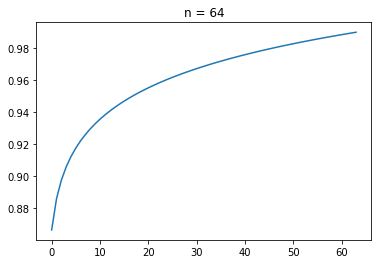

In [24]:
plt.plot([sens_group(n = 64, k = k, sp = 0.99, sens_i = 0.99, alpha = 0.0324, beta = 0) for k in range(1, 65)])
plt.title('n = 64')

In [3]:
import numpy as np
import math

In [4]:
math.comb(5, 2)

10

In [5]:
def obj(p,n,sp, sens_i, alpha, beta):
    temp = sum([(sens_group(n, k, sp, sens_i, alpha, beta) * math.comb(n, k) * (p/(1-p)) ** k) for k in range(1, n+1)])
    return ((1-p) ** n * (1/(1-p) ** n + n - n*sp + n * temp)) / n


In [6]:
sens_group(10,0, 0.99, 0.99, 0.0324, -0.001255)

0.99

In [7]:
obj(0.01, 10, 0.99, 0.99, 0.0324, -0.001255)

0.19693323127991422

In [6]:
def linear_scan(n_max, p, sp, sens_i, alpha, beta):
    temp = [obj(p, n, sp, sens_i, alpha, beta) for n in range(1, n_max+1)]
    return temp.index(min(temp)) + 1
    



In [9]:
import fast_btk as fbtk

In [10]:
fbtk.one_batch_test_solver(0.01, 0.01, 0.01)

10.629026526725156

In [11]:
linear_scan(32, 0.01, 0.99, 0.99, 0.0324, -0.001255)

11

In [12]:
sens_group(32, 0, 0.99, 0.99, 0.0324, -0.001255)

0.99

In [7]:
infection_rate = np.arange(0.001, 0.3, 0.001)

In [8]:
batch_size = [linear_scan(32, p, 0.99, 0.99, 0.0324, -0.001255) for p in infection_rate]

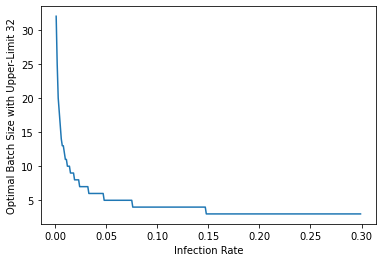

In [9]:
plt.plot(infection_rate, batch_size)
plt.ylabel('Optimal Batch Size with Upper-Limit 32')
plt.xlabel('Infection Rate')
plt.savefig('opt_batch_fig')

In [32]:
def neg_pos_batch_split(subject_array, batch_size, sp, sens_i, alpha, beta):
    """
    A function gives a list of sujects on the negative batch(es),
    a list of subjects on the postive batch(es) and the test-kit 
    consumption given the probability of type II error, the 
    probability of Type I error.
    
    Input:
        subject_array (Numpy Array): an array contains subject id and subject's
        condition (1 stands for infection and 0 stands for uninfection)
        batch_size (int): batch size
        typeII_error (float): probability of type II error 
        typeI_error (float): probability of type I error
        

    Output:
        neg_batch (Numpy Array): an array of subjects on the negative batch(es)
        pos_batch (Numpy Array): an array of subjects on the postive batch(es)
        test_consum (int): the number of test-kit consumptions
        
    """
    typeI_error = 1 - sp
    #sens_group(n, k, sp, sens_i, alpha, beta)
    neg_batch = []
    pos_batch = []
    test_consum = np.ceil(len(subject_array)/batch_size)
    random_table = np.random.uniform(0, 1, int(test_consum))
    i = 0
    for temp_batch in np.array_split(subject_array, test_consum):
        if 1 in (temp_batch[:,1]):
            k = sum(temp_batch[:,1])
            typeII_error = 1-sens_group(batch_size, k, sp, sens_i, alpha, beta)
            if random_table[i] > typeII_error:
                pos_batch.append(temp_batch)
            else:
                neg_batch.append(temp_batch)
        else:
            if random_table[i] > typeI_error:
                neg_batch.append(temp_batch)
            else:
                pos_batch.append(temp_batch)
        i += 1
    neg_batch = np.concatenate(neg_batch) if len(neg_batch) > 0 else np.array([])
    pos_batch = np.concatenate(pos_batch) if len(pos_batch) > 0 else np.array([])
    return (neg_batch, pos_batch, test_consum)

In [17]:
import fast_btk as fbtk

In [18]:
sens_group(10,0, 0.99, 0.99, 0.0324, -0.001255)

0.99

In [19]:
subject_array = fbtk.data_gen(100, 0.1)
batch_size = linear_scan(32, 0.1, 0.99, 0.99, 0.0324, -0.001255)
sp, sens_i = 0.99, 0.99
alpha = 0.0324
beta = -0.001255

/home/hajiang/Desktop/batch_testing/fast_btk.py:381: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "data_gen" failed type inference due to: No implementation of function Function(<built-in function zeros>) found for signature:
 
 >>> zeros(Tuple(int64, Literal[int](2)), dtype=Function(<class 'int'>))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload of function 'zeros': File: numba/core/typing/npydecl.py: Line 507.
    With argument(s): '(UniTuple(int64 x 2), dtype=Function(<class 'int'>))':
   No match.

During: resolving callee type: Function(<built-in function zeros>)
During: typing of call at /home/hajiang/Desktop/batch_testing/fast_btk.py (396)


File "fast_btk.py", line 396:
def data_gen(size, p):
    <source elided>
    random_table = np.random.binomial(size = size, p = p, n = 1)
    test_array = np.zeros((size, 2), dtype = np.int)
    ^

  @jit(parallel = True)
/home/hajiang/Desktop/bat

In [20]:
neg_pos_batch_split(subject_array, batch_size, sp, sens_i, alpha, beta)
k = sum(temp_batch[:,1])
typeII_error = 1-sens_group(batch_size, k, sp, sens_i, alpha, beta)

NameError: name 'temp_batch' is not defined

In [21]:
helpfunction(subject_array, 0.1, batch_size, sp, sens_i, alpha, beta, batch_limit = 32)

NameError: name 'helpfunction' is not defined

In [28]:

def helpfunction(subject_array, p, batch_size ,sp, sens_i, alpha, beta, batch_limit):
    
    """
    The helpfunction is a handy function to give the list of subjects on the
    negative batch(es), the list of subjects on the postive batch(es), the 
    test-kit consumption, the infection rate on the negative batches, the 
    infection rate on the positive batches, the optimal batch size for
    negative batches and the optimal batch size for positive batches.

    Input: 
        subject_array (Numpy Array): an array contains subject id and subject's
        condition (1 stands for infection and 0 stands for uninfection)
        p (float): Infection rate
        batch_size (int): batch size
        typeII_error (float): probability of type II error 
        typeI_error (float): probability of type I error
        batch_limit (int): batch size upper limit

    Output:
        temp0 (Numpy Array): an array of subjects on the negative batch(es)
        temp1 (Numpy Array): an array of subjects on the postive batch(es)
        temp_con (int): the number of test-kit consumptions
        p0 (float): the infection rate on the negative batches
        p1 (float): the infection rate on the positive batches
        n0 (float): the optimal batch size for the negative batches
        n1 (float): the optimal batch size for the positive batches
    """
    batch_size = min(batch_size, batch_limit)
    typeI_error = 1-sp
    k = np.floor(batch_size * p)
    typeII_error = 1 - sens_group(batch_size, k, sp, sens_i, alpha, beta)
    #print(typeII_error)

    p0 = fbtk.infection_rate_on_negative_batch(p, batch_size, typeII_error, typeI_error)
    p1 = fbtk.infection_rate_on_positive_batch(p, batch_size, typeII_error, typeI_error)
    n0= linear_scan(batch_limit, p0, sp, sens_i, alpha, beta)
    n1 = linear_scan(batch_limit, p1, sp, sens_i, alpha, beta)
    if subject_array == np.array([]):
        return (np.array([]), np.array([]), p0, p1, n0, n1)
    temp0, temp1, temp_con = neg_pos_batch_split(subject_array, batch_size, sp, sens_i, alpha, beta)
    return(temp0, temp1, temp_con, p0, p1, n0, n1)

In [33]:

def seq_test(subject_array,stop_rule,p, batch_size, sp, sens_i, alpha, beta, repeat = 1, 
prob_threshold = 1, seq = True, batch_limit = 32):
    """
    A function gives the test results to a subject array and the total number of 
    test-kit consumption and the individual testing number given the subject array,
    the stop rule, the batch size, the probability of type II error, the probability of 
    Type I error, and the number of repeatition, the probability threshold, and 
    setting of sequence testing or not.
    
    Input:
        subject_array(Numpy Array): an array contains subject id and subject's
        condition (1 stands for infection and 0 stands for uninfection)
        stop_rule (int): the number of postive batches to enter individual testing
        p (float): infection rate
        batch_size (int): batch size
        typeII_error (float): probability of type II error 
        typeI_error (float): probability of type I error
        repeat (int): the number of repetition 
        prob_threshold (float): if the infection rate of a batch is beyond prob_threshold, 
        the subjects on that batch will enter individual testing phase
        seq (boolean): True stands for sequential testing. The test will end
        when the test result is positive or run up the number of repetition.
        False stands for simutanlous testing with majority voting.
        batch_limit (int):

    Output:
        result (Numpy Array): an array contains subjects' id and test results
        consum (int): the total test consumption
        individual_con (int): the test consumption for individual testings

    """
    temp_list = []
    neg_list = []
    pos_list = []
    consum = 0
    temp = {'data': subject_array,
           'NB_Num': 0,
           'PB_Num': 0,
           'p': p,
           'batch_size': batch_size}
    temp_list.append(temp)
    new_list = []
    neg_array = []
    pos_array = []
    while len(temp_list) > 0:
        for i in temp_list:
            temp0, temp1, temp_con, p0, p1, n0, n1 = helpfunction(i['data'], i['p'], i['batch_size'],
                                                                           sp, sens_i, alpha, beta, batch_limit)
            temp0 = {'data': temp0,
                    'NB_Num': i['NB_Num'] + 1,
                    'PB_Num': i['PB_Num'],
                    'p': p0,
                    'batch_size': n0}
            temp1 = {'data': temp1,
                    'NB_Num': i['NB_Num'],
                    'PB_Num': i['PB_Num'] + 1,
                    'p': p1,
                    'batch_size': n1}
            if len(temp0['data']) > 0:
                if temp0['NB_Num'] >= stop_rule:
                    neg_list.append(temp0)
                else:
                    new_list.append(temp0)
            
            if len(temp1['data'])>0:
                if temp1['PB_Num'] >= stop_rule or temp1['p']>=prob_threshold:
                    pos_list.append(temp1)
                else:
                    new_list.append(temp1)
            consum += temp_con 
        temp_list = new_list
        new_list = []
        #print(temp_list)
    for j in neg_list:
        neg_array.append(j['data'])
    neg_array = np.concatenate(neg_array)
    for k in pos_list:
        pos_array.append(k['data'])
    pos_array = np.concatenate(pos_array)
        
    neg_array[:,1] = 0
    individual_test, individual_con = fbtk.conventional_test(pos_array, 1-sens_i, 1-sp, repeat, seq)
    pos_array = individual_test
    consum += individual_con
    result = np.concatenate((pos_array, neg_array))
    result = result[result[:,0].argsort()]
    result = result.astype('int64')
    return (result, consum, individual_con)

In [34]:
batch_size = linear_scan(32, 0.1, 0.99, 0.99, 0.0324, -0.001255)
sp, sens_i = 0.99, 0.99
alpha = 0.0324
beta = -0.001255

In [35]:
a,b, c = seq_test(subject_array,stop_rule = 2,p = 0.1, batch_size = 5, sp = 0.99, sens_i = 0.99, alpha = 0.0324, beta = -0.001255, repeat = 1, 
prob_threshold = 1, seq = True, batch_limit = 32)

<ipython-input-28-bfa62db736d0>:38: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if subject_array == np.array([]):


In [36]:
np.mean(a[:,1] == subject_array[:,1])

1.0

In [37]:
a

array([[ 0,  0],
       [ 1,  0],
       [ 2,  0],
       [ 3,  0],
       [ 4,  0],
       [ 5,  0],
       [ 6,  0],
       [ 7,  0],
       [ 8,  0],
       [ 9,  0],
       [10,  0],
       [11,  0],
       [12,  1],
       [13,  0],
       [14,  0],
       [15,  0],
       [16,  0],
       [17,  0],
       [18,  0],
       [19,  0],
       [20,  0],
       [21,  0],
       [22,  0],
       [23,  0],
       [24,  0],
       [25,  0],
       [26,  1],
       [27,  0],
       [28,  0],
       [29,  0],
       [30,  0],
       [31,  1],
       [32,  0],
       [33,  0],
       [34,  0],
       [35,  0],
       [36,  0],
       [37,  0],
       [38,  0],
       [39,  0],
       [40,  0],
       [41,  0],
       [42,  0],
       [43,  0],
       [44,  0],
       [45,  0],
       [46,  0],
       [47,  0],
       [48,  0],
       [49,  1],
       [50,  0],
       [51,  0],
       [52,  0],
       [53,  1],
       [54,  0],
       [55,  0],
       [56,  0],
       [57,  0],
       [58,  0